In [4]:
%pip install gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gdown

Note: you may need to restart the kernel to use updated packages.


## Helper functions

In [5]:
def fetch_dataset(key, dataset_name):
    cmd = !gdown --fuzzy {key} -O {dataset_name}
    path = pd.Series(cmd).str.extractall(r'(To.*)').reset_index()[0].iloc[0].split(': ')[1]
    print(f'{dataset_name} path: {path}')
    return path

def get_null_percentage(df):
    null_series = ((df.isnull().sum()/len(df))*100).sort_values()
    return null_series

def generate_time_features(df):
    df = df.reset_index()
    df.loc[:,'day']  = df['Order Date'].dt.day
    df.loc[:,'month']  = df['Order Date'].dt.month
    df.loc[:,'year']  = df['Order Date'].dt.year
    df.loc[:,'is_weekend']  = df['Order Date'].dt.weekday > 5
    df.loc[:,'day_of_week']  = df['Order Date'].dt.day_of_week
    df.loc[:,'day_of_year']  = df['Order Date'].dt.day_of_year
    df.loc[:,'quarter']  = df['Order Date'].dt.quarter
    df.loc[:,'is_month_start']  = df['Order Date'].dt.is_month_start
    df.loc[:,'is_month_end']  = df['Order Date'].dt.is_month_end
    df.loc[:,'is_year_start']  = df['Order Date'].dt.is_year_start
    df.loc[:,'is_year_end']  = df['Order Date'].dt.is_year_end
    df = df.set_index('Order Date')
    return df

def add_holidays_past_2021(df):

    _2022 = pd.Series(['2022-12-26', '2022-11-24', '2022-11-11', '2022-10-10', '2022-09-05', '2022-07-04', '2022-06-20', '2022-05-30', '2022-02-21', '2022-01-21', '2023-01-02', '2023-01-16', '2023-02-20']) 
    
    _2022 = pd.to_datetime(_2022)
    dates = pd.Series(['January 02 2023',
    'January 16 2023',
    'February 20 2023',
    'May 29 2023',
    'June 19 2023',
    'July 04 2023',
    'September 04 2023',
    'October 09 2023',
    'November 10 2023',
    'November 23 2023',
    'December 25 2023',
    'January 01 2024',
    'January 15 2024',
    'February 19 2024',
    'May 27 2024',
    'June 19 2024',
    'July 04 2024',
    'September 02 2024',	
    'October 14 2024',
    'November 11 2024',	
    'November 28 2024',	
    'December 25 2024',
    'January 01 2025',
    'January 20 2025',
    'January 20 2025',
    'February 17 2025',
    'May 26 2025',
    'June 19 2025',
    'July 04 2025',
    'September 01 2025',	
    'October 13 2025',
    'November 11 2025',
    'November 27 2025',
    'December 25 2025',
    'January 01 2026',
    'January 19 2026',
    'February 16 2026',
    'May 25 2026',
    'June 19 2026',
    'July 03 2026',
    'September 07 2025',
    'October 12 2026',
    'November 11 2026',
    'November 26 2026',
    'December 25 2026'
                      ])
    fedral_holidays_2023_plus = pd.to_datetime(dates)
    fedral_holdidays_22_plus = pd.concat([_2022, fedral_holidays_2023_plus], axis=0).sort_values()
    fedral_holdidays_22_plus = pd.Series(fedral_holdidays_22_plus.unique())
    fedral_holdidays_22_plus.index = range(len(fedral_holdidays_22_plus))
    fedral_holdidays_22_plus = pd.DataFrame(fedral_holdidays_22_plus).rename(columns={0:'date'})
    fedral_holdidays_22_plus['fedral_holiday'] = True
    fedral_holdidays_22_plus = fedral_holdidays_22_plus.set_index('date')
    return pd.merge(df, fedral_holdidays_22_plus, how='left', left_index = True, right_index=True)

## Purchases Dataset

In [6]:
path = fetch_dataset("1HdJj68eO9NTZlpwZcLYqdtPqrbKs1cxj", "amazon_purchases.csv")

amazon_purchases.csv path: c:\Users\shwet\Documents\Spring 2025\DS 5010\Final Project\AmazonSalesPredictor\amazon_purchases.csv


In [7]:
purchases = pd.read_csv(path)

In [8]:
purchases.rename(columns={'ASIN/ISBN (Product Code)': 'product_code'}, inplace=True)

In [9]:
purchases['Order Date'] = pd.to_datetime(purchases['Order Date'])

In [10]:
purchases.sort_values(by='Order Date', inplace=True)

In [11]:
purchases= purchases[purchases['Order Date'].dt.year<2023]

In [12]:
purchases

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,product_code,Category,Survey ResponseID
1067944,2018-01-01,29.99,1.0,GA,LEGO Super Heroes DC Wonder Woman Warrior Batt...,B072HT813T,TOYS_AND_GAMES,R_3HzRfw5sNEvrFRf
977510,2018-01-01,11.99,1.0,NaN,"OLIKEME Women's Shapewear,Adjustable High Wais...",B074TY774J,UNDERGARMENT_THIGH_SLIMMER,R_32VcKmw1biSyknq
977511,2018-01-01,9.45,1.0,NaN,How to Traumatize Your Children: 7 Proven Meth...,1601063091,BLANK_BOOK,R_32VcKmw1biSyknq
977512,2018-01-01,13.42,1.0,NaN,Sh*t My Kids Ruined: An A-Z Celebration of Kid...,034552716X,ABIS_BOOK,R_32VcKmw1biSyknq
977513,2018-01-01,6.99,1.0,TX,Ohyeah Women's Mesh T Back Artificial Pearls S...,B014K342XS,UNDERPANTS,R_32VcKmw1biSyknq
...,...,...,...,...,...,...,...,...
836153,2022-12-31,29.96,1.0,CA,Lezonic Rechargeable LED Flameless Pillar Cand...,B08Y6LVPW5,LAMP,R_2r7Zl5CTeW1dMqd
883628,2022-12-31,23.40,1.0,AZ,"Spotted Zebra Girls and Toddlers' Leggings, Mu...",B07979NP2M,PANTS,R_2vYO5d3Ry8qjf5g
883627,2022-12-31,28.50,1.0,AZ,Spotted Zebra Girls and Toddlers' Long-Sleeve ...,B07GQCQBJ2,SHIRT,R_2vYO5d3Ry8qjf5g
203927,2022-12-31,11.78,1.0,NC,Fisher Snack Oven Roasted Never Fried Whole Ca...,B089LJLC3S,NUT_AND_SEED,R_1Oov0G05pkQnKNn


In [13]:
purchases['total_sales'] = purchases['Quantity'] * purchases['Purchase Price Per Unit']

# EDA

In [14]:
years_of_interest = ['2018-01-01', '2018-12-31', '2019-01-01', '2019-12-31', '2020-01-01', '2020-12-31', '2021-01-01', '2021-12-31', '2022-01-01', '2022-12-31']

In [15]:
purchases_clipped =  purchases[purchases['Order Date'].isin([pd.to_datetime(year) for year in years_of_interest])]

In [16]:
purchases_clipped['Order Date'].value_counts().sort_index()

Order Date
2018-01-01     639
2018-12-31     513
2019-01-01     621
2019-12-31     692
2020-01-01     829
2020-12-31    1277
2021-01-01    1319
2021-12-31    1026
2022-01-01    1135
2022-12-31     595
Name: count, dtype: int64

Text(0.5, 1.0, 'States with the most mean')

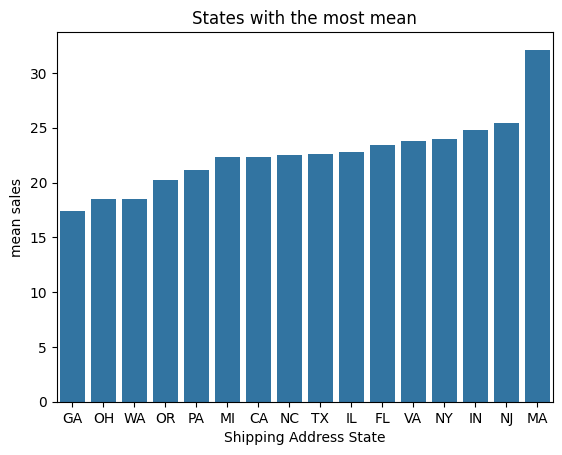

In [17]:
sns.barplot(purchases_clipped.groupby('Shipping Address State')['total_sales'].mean().loc[['MA', 'MI', 'IN', 'PA', 'TX', 'OH', 'NJ', 'WA', 'VA', 'NY', 'OR', 'NC',
       'CA', 'IL', 'GA', 'FL']].sort_values())
plt.ylabel('mean sales')
plt.title('States with the most mean')

Text(0.5, 1.0, 'States with the most standard deviation')

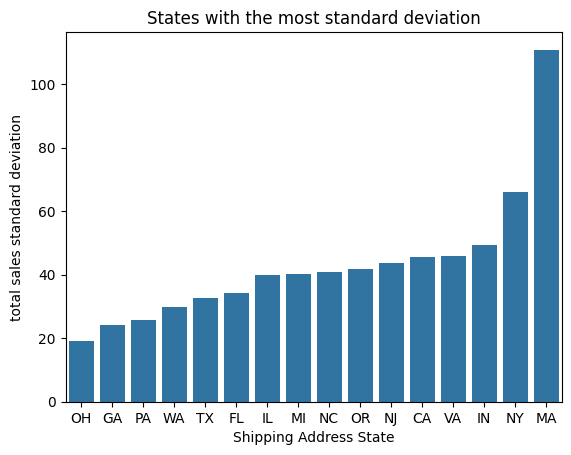

In [18]:
sns.barplot(purchases_clipped.groupby('Shipping Address State')['total_sales'].std().loc[['MA', 'MI', 'IN', 'PA', 'TX', 'OH', 'NJ', 'WA', 'VA', 'NY', 'OR', 'NC',
       'CA', 'IL', 'GA', 'FL']].sort_values())
plt.ylabel('total sales standard deviation')
plt.title('States with the most standard deviation')

Text(0, 0.5, 'total sales')

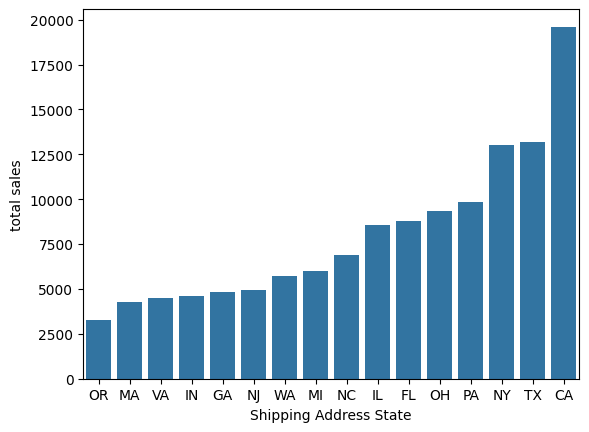

In [19]:
sns.barplot(purchases_clipped.groupby('Shipping Address State')['total_sales'].sum().loc[['MA', 'MI', 'IN', 'PA', 'TX', 'OH', 'NJ', 'WA', 'VA', 'NY', 'OR', 'NC',
       'CA', 'IL', 'GA', 'FL']].sort_values())
plt.ylabel('total sales')


In [20]:
states_frequencies = purchases.groupby(['Order Date', 'Shipping Address State'])['total_sales'].sum().reset_index()['Shipping Address State'].value_counts().sort_values()

In [21]:
states_frequencies.index

Index(['PR', 'WY', 'ND', 'AK', 'SD', 'MT', 'VT', 'RI', 'HI', 'ID', 'ME', 'DE',
       'NM', 'DC', 'WV', 'IA', 'NH', 'MS', 'UT', 'KS', 'OK', 'AR', 'NE', 'CT',
       'NV', 'SC', 'AL', 'MO', 'LA', 'AZ', 'CO', 'MD', 'TN', 'MN', 'KY', 'WI',
       'MA', 'MI', 'IN', 'PA', 'TX', 'OH', 'NJ', 'WA', 'VA', 'NY', 'OR', 'NC',
       'CA', 'IL', 'GA', 'FL'],
      dtype='object', name='Shipping Address State')

Text(0.5, 1.0, 'States by frequency')

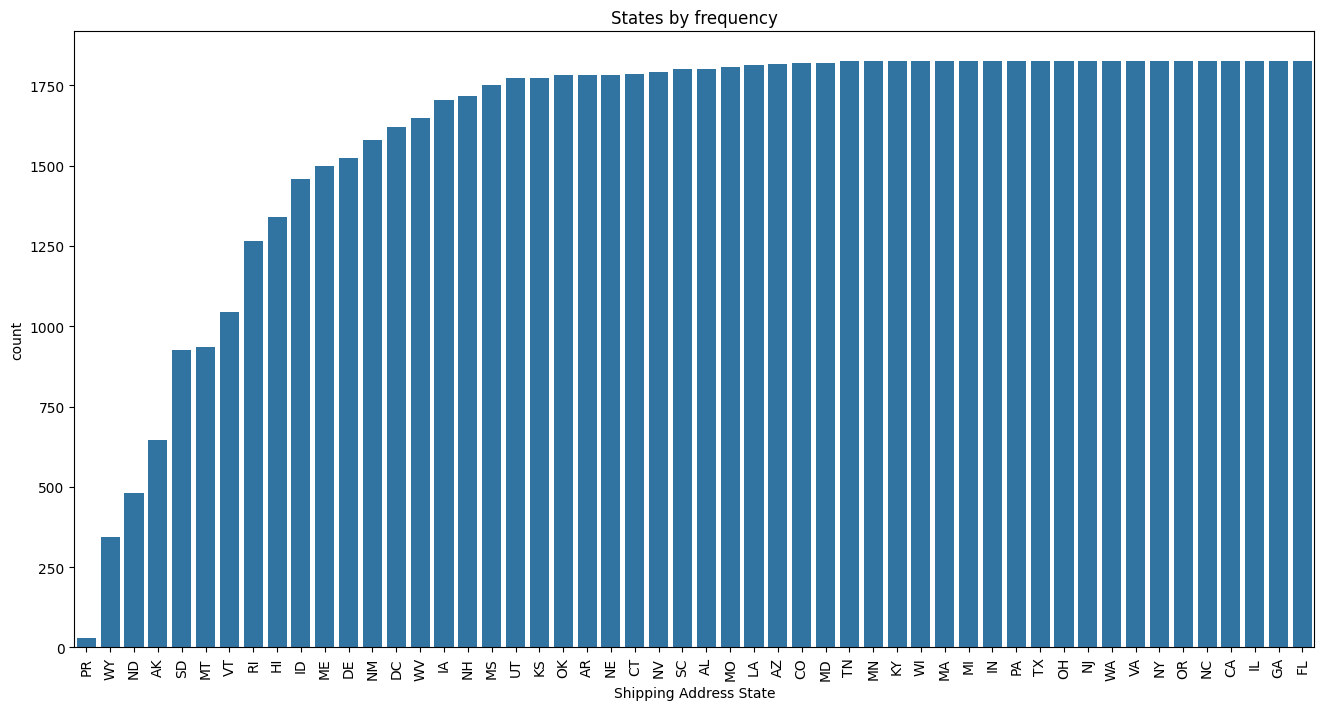

In [22]:
plt.figure(dpi=100, figsize=(16,8))
sns.barplot(x = states_frequencies.index, y =states_frequencies )
plt.xticks(rotation=90);
plt.title('States by frequency')

<Axes: xlabel='Order Date'>

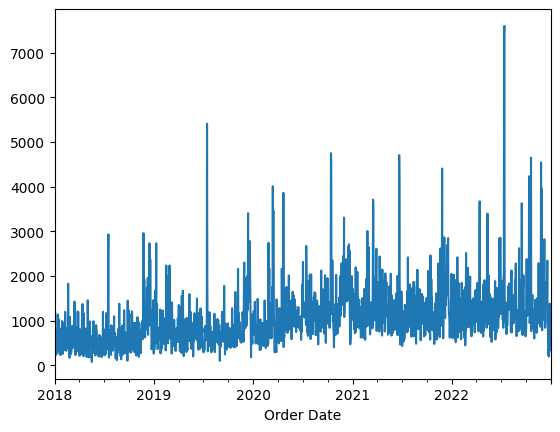

In [23]:
purchases[purchases['Shipping Address State'] == 'OH'].groupby('Order Date')['total_sales'].sum().plot()

<Axes: xlabel='Order Date'>

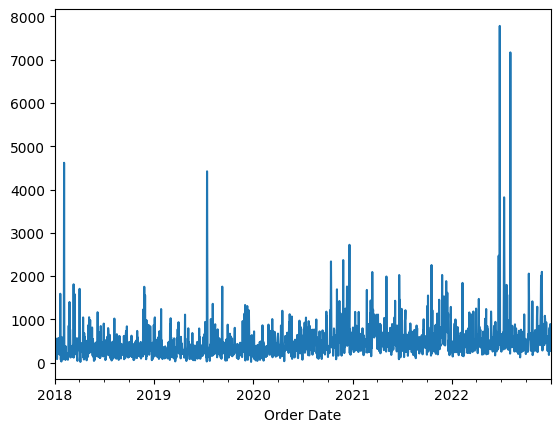

In [24]:
purchases[purchases['Shipping Address State'] == 'OR'].groupby('Order Date')['total_sales'].sum().plot()

Text(0.5, 1.0, 'Total sales in GA')

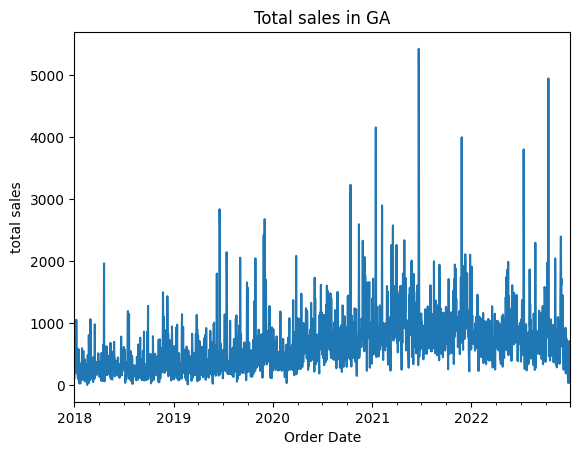

In [25]:
purchases[purchases['Shipping Address State'] == 'GA'].groupby('Order Date')['total_sales'].sum().plot()
plt.ylabel('total sales')
plt.title('Total sales in GA')

Text(0.5, 1.0, 'Total sales in CA')

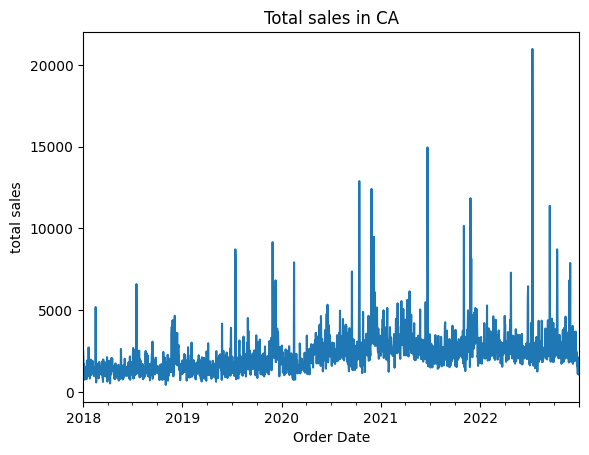

In [26]:
purchases[purchases['Shipping Address State'] == 'CA'].groupby('Order Date')['total_sales'].sum().plot()
plt.ylabel('total sales')
plt.title('Total sales in CA')

CA best performer
GA least performer

## Categories Dataset

In [27]:
path = fetch_dataset("19167R4OV0GWNiCHTh3w9T07616S91enj", "amazon_categories.csv")

amazon_categories.csv path: c:\Users\shwet\Documents\Spring 2025\DS 5010\Final Project\AmazonSalesPredictor\amazon_categories.csv


In [28]:
categories = pd.read_csv(path)

In [29]:
categories

,id,category_name
0,1,Beading & Jewelry Making
1,2,Fabric Decorating
2,3,Knitting & Crochet Supplies
3,4,Printmaking Supplies
4,5,Scrapbooking & Stamping Supplies
...,...,...
243,262,"Xbox Series X & S Consoles, Games & Accessories"
244,263,PC Games & Accessories
245,264,Baby Girls' Clothing & Shoes
246,265,Boys' School Uniforms


# Products Dataset

In [30]:
path = fetch_dataset("1yoaKl-7wctxH315gH_M15fS5WERnFlHe", "amazon_products.csv")

amazon_products.csv path: c:\Users\shwet\Documents\Spring 2025\DS 5010\Final Project\AmazonSalesPredictor\amazon_products.csv


In [31]:
products = pd.read_csv(path)
products = products.rename(columns={'asin':'product_code'})

In [32]:
products = pd.merge(products, categories, how='inner', left_on='category_id', right_on='id').drop('id', axis=1)

In [33]:
products

,product_code,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth,category_name
0,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",https://m.media-amazon.com/images/I/815dLQKYIY...,https://www.amazon.com/dp/B014TMV5YE,4.5,0,139.99,0.00,104,False,2000,Suitcases
1,B07GDLCQXV,Luggage Sets Expandable PC+ABS Durable Suitcas...,https://m.media-amazon.com/images/I/81bQlm7vf6...,https://www.amazon.com/dp/B07GDLCQXV,4.5,0,169.99,209.99,104,False,1000,Suitcases
2,B07XSCCZYG,Platinum Elite Softside Expandable Checked Lug...,https://m.media-amazon.com/images/I/71EA35zvJB...,https://www.amazon.com/dp/B07XSCCZYG,4.6,0,365.49,429.99,104,False,300,Suitcases
3,B08MVFKGJM,Freeform Hardside Expandable with Double Spinn...,https://m.media-amazon.com/images/I/91k6NYLQyI...,https://www.amazon.com/dp/B08MVFKGJM,4.6,0,291.59,354.37,104,False,400,Suitcases
4,B01DJLKZBA,Winfield 2 Hardside Expandable Luggage with Sp...,https://m.media-amazon.com/images/I/61NJoaZcP9...,https://www.amazon.com/dp/B01DJLKZBA,4.5,0,174.99,309.99,104,False,400,Suitcases
...,...,...,...,...,...,...,...,...,...,...,...,...
1426332,B00R3LIKCO,American Flag Patriotic USA Classic 5 Panel Me...,https://m.media-amazon.com/images/I/71PDJFz6AA...,https://www.amazon.com/dp/B00R3LIKCO,4.2,0,14.95,0.00,112,False,0,Men's Accessories
1426333,B098BQ7ZQ3,Men's Baseball Cap - H2O-DRI Line Up Curved Br...,https://m.media-amazon.com/images/I/812Tycexs4...,https://www.amazon.com/dp/B098BQ7ZQ3,4.4,0,33.99,0.00,112,False,0,Men's Accessories
1426334,B07X1MVNT1,[4 Pack] Adjustable Eyeglasses and Sunglasses ...,https://m.media-amazon.com/images/I/61vvYW1S9J...,https://www.amazon.com/dp/B07X1MVNT1,3.6,0,8.54,0.00,112,False,0,Men's Accessories
1426335,B08XLBG8V9,Ax2002 Aviator Sunglasses,https://m.media-amazon.com/images/I/51+yjD4F1x...,https://www.amazon.com/dp/B08XLBG8V9,4.5,0,54.36,57.39,112,False,0,Men's Accessories


In [34]:
purchases[purchases['product_code'] == 'B07TF72BMC']

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,product_code,Category,Survey ResponseID,total_sales
1524776,2022-08-06,21.98,3.0,NC,MAGCOMSEN Men's Polo Shirt Quick Dry Performan...,B07TF72BMC,NaN,R_OiYmnNVvK5ABUK5,65.94


In [35]:
product_codes_category_null = purchases[purchases['Category'].isnull()]['product_code']

data_replacements = products[products['product_code'].isin(product_codes_category_null.unique())][['product_code','title','category_name']]

purchases = pd.merge(purchases, data_replacements, on='product_code', how='left')

purchases.loc[(purchases['Category'].isnull())&(purchases['category_name'].notnull()), 'Category'] = purchases.loc[(purchases['Category'].isnull())&(purchases['category_name'].notnull()), 'category_name']

purchases.loc[(purchases['Title'].isnull()) & (purchases['title'].notnull()), 'Title'] = purchases.loc[(purchases['Title'].isnull()) & (purchases['title'].notnull()), 'title']

In [36]:
purchases[purchases['product_code'] == 'B07TF72BMC']

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,product_code,Category,Survey ResponseID,total_sales,title,category_name
1632833,2022-08-06,21.98,3.0,NC,MAGCOMSEN Men's Polo Shirt Quick Dry Performan...,B07TF72BMC,Men's Clothing,R_OiYmnNVvK5ABUK5,65.94,Men's Polo Shirt Quick Dry Performance Short S...,Men's Clothing


In [37]:
purchases.drop(['title', 'category_name'], axis=1, inplace=True)

In [38]:
get_null_percentage(purchases)

Order Date                 0.000000
Purchase Price Per Unit    0.000000
Quantity                   0.000000
Survey ResponseID          0.000000
total_sales                0.000000
product_code               0.053181
Shipping Address State     4.740133
Category                   4.856878
Title                      4.875046
dtype: float64

In [39]:
purchases[purchases['Shipping Address State'].isnull() & purchases['Category'].isnull()]

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,product_code,Category,Survey ResponseID,total_sales
23,2018-01-01,6.50,1.0,NaN,NaN,B00IDZZ96Y,NaN,R_32VcKmw1biSyknq,6.50
218,2018-01-01,14.99,1.0,NaN,NaN,B073PK9K12,NaN,R_3HNOpheZEt8babI,14.99
304,2018-01-01,99.99,1.0,NaN,NaN,B074SXDRC3,NaN,R_25u6PwLCFpZwuzY,99.99
1366,2018-01-03,44.99,1.0,NaN,NaN,B075R9KYM7,NaN,R_T7v2MVF1Q9nTL2N,44.99
1992,2018-01-04,18.93,1.0,NaN,NaN,B017DX9CRI,NaN,R_1ONrCkUEhKm1LZY,18.93
...,...,...,...,...,...,...,...,...,...
1803513,2022-12-21,50.00,1.0,NaN,NaN,B0BHRC27H1,NaN,R_3j7P0eEOFqWjGrT,50.00
1803970,2022-12-22,20.00,1.0,NaN,NaN,B0BHR6VFCB,NaN,R_24csoaO569P4Yzz,20.00
1804034,2022-12-22,15.00,1.0,NaN,NaN,B0BHRB7GZV,NaN,R_1JJ8YCoLzDqN39u,15.00
1805116,2022-12-24,13.57,1.0,NaN,NaN,B0BHTLHT96,NaN,R_3JnjKsPAuFGDhrx,13.57


In [40]:
get_null_percentage(purchases.dropna(axis=0,subset= ['Shipping Address State','Category']))

Order Date                 0.000000
Purchase Price Per Unit    0.000000
Quantity                   0.000000
Shipping Address State     0.000000
Survey ResponseID          0.000000
Category                   0.000000
total_sales                0.000000
product_code               0.017080
Title                      0.032147
dtype: float64

In [41]:
purchases.dropna(axis=0,subset= ['Shipping Address State','Category'], inplace=True)

In [42]:
purchases

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,product_code,Category,Survey ResponseID,total_sales
0,2018-01-01,29.99,1.0,GA,LEGO Super Heroes DC Wonder Woman Warrior Batt...,B072HT813T,TOYS_AND_GAMES,R_3HzRfw5sNEvrFRf,29.99
4,2018-01-01,6.99,1.0,TX,Ohyeah Women's Mesh T Back Artificial Pearls S...,B014K342XS,UNDERPANTS,R_32VcKmw1biSyknq,6.99
5,2018-01-01,21.90,2.0,UT,STRATTON MEN’S ADJUSTABLE SPLIT TOE CEDAR SHOE...,B01J0AHEDQ,SHOE_TREE,R_1DULPnUes4caEHg,43.80
6,2018-01-01,13.99,1.0,NY,BALI SECRETS All Natural Deodorant for Women &...,B012E9DMNQ,BODY_DEODORANT,R_333cPUAJRgYXqi1,13.99
7,2018-01-01,8.59,1.0,MN,G4Free 15L Drawstring Backpack 15L&20L Cinch B...,B01EHIOHZ4,BACKPACK,R_2S0u8lcDVOW3xTU,8.59
...,...,...,...,...,...,...,...,...,...
1810788,2022-12-31,29.96,1.0,CA,Lezonic Rechargeable LED Flameless Pillar Cand...,B08Y6LVPW5,LAMP,R_2r7Zl5CTeW1dMqd,29.96
1810789,2022-12-31,23.40,1.0,AZ,"Spotted Zebra Girls and Toddlers' Leggings, Mu...",B07979NP2M,PANTS,R_2vYO5d3Ry8qjf5g,23.40
1810790,2022-12-31,28.50,1.0,AZ,Spotted Zebra Girls and Toddlers' Long-Sleeve ...,B07GQCQBJ2,SHIRT,R_2vYO5d3Ry8qjf5g,28.50
1810791,2022-12-31,11.78,1.0,NC,Fisher Snack Oven Roasted Never Fried Whole Ca...,B089LJLC3S,NUT_AND_SEED,R_1Oov0G05pkQnKNn,11.78


# EDA

In [43]:
category_frequencies = purchases.groupby(['Order Date', 'Category'])['total_sales'].sum().reset_index()['Category'].value_counts().sort_values()

In [44]:
category_frequencies

Category
AGRICULTURAL_SUPPLIES        1
THERMISTOR                   1
POWER_RACK                   1
LAB_UTENSIL                  1
VIDEO_DEVICE                 1
                          ... 
PET_FOOD                  1825
ELECTRONIC_CABLE          1825
HEALTH_PERSONAL_CARE      1825
NUTRITIONAL_SUPPLEMENT    1826
ABIS_BOOK                 1826
Name: count, Length: 1981, dtype: int64

In [45]:
category = []
for i in range(max(category_frequencies)):
    indices = category_frequencies[category_frequencies==i].index
    for index in indices:
        if len(purchases[purchases['Category'] == index].groupby(purchases['Order Date'].dt.year)['Category'].count()) == 5:
            category.append(index)

In [46]:
category

['DOWNLOADABLE_SOFTWARE',
 'MOTORCYCLE_PART',
 'MUSIC_POPULAR',
 'Automotive Replacement Parts',
 'WINDOW_INSULATION_KIT',
 'SPORT_BINDING',
 'TOW_SPORTS_LINE',
 'PORTABLE_AV_DEVICE',
 'COMPUTER_SPEAKER',
 'Heating, Cooling & Air Quality',
 'BOX_SPRING',
 'VEHICLE_SPOILER',
 'ELECTRONIC_CONTROLLER',
 'RAM_MEMORY',
 'CUTICLE_PUSHER',
 'HAND_FAN',
 'GOURMET_FOOD',
 'PHOTOGRAPHIC_STUDIO_ITEMS',
 'CAMERA_LENS_ACCESSORY',
 'Craft Supplies & Materials',
 'ALCOHOLIC_BEVERAGE',
 'ARTIFICIAL_SNOW',
 'HOT_TUB',
 'FLOOR_COVER',
 'FUEL_LAMP',
 'Sexual Wellness Products',
 'COSTUME_FACIAL_HAIR',
 'CORRECTION_MATERIAL',
 'CARD_SHUFFLER',
 'SHAVING_BRUSH',
 'FREEZER',
 'ABIS_ELECTRONICS',
 'FLASK',
 'KEYBOARD_TRAY',
 'PERCUSSION_INSTRUMENTS',
 'SHOE_POLISH',
 'ABIS_SPORTS',
 'Professional Medical Supplies',
 'Bedding',
 'DAILY_LIVING_AIDS',
 'Automotive Tools & Equipment',
 'DIGITAL_VIDEO_RECORDER',
 'Games & Accessories',
 'COOKING_OVEN',
 'PLAYHOUSE',
 'ABIS_HOME',
 'ENTERTAINMENT_MEMORABILIA',
 'I

In [47]:
category_frequencies[category_frequencies.index=='BEER']

Category
BEER    220
Name: count, dtype: int64

In [48]:
purchases[purchases['Category'] == 'BEER'].groupby(purchases['Order Date'].dt.year)['Category'].count()

Order Date
2019      2
2020    108
2021    106
2022    137
Name: Category, dtype: int64

In [49]:
purchases[purchases['Category'] == 'HEADPHONES']

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,product_code,Category,Survey ResponseID,total_sales
275,2018-01-01,99.99,1.0,TX,SteelSeries Arctis 7 Lag-Free Wireless Gaming ...,B01LYNEIEI,HEADPHONES,R_O9FzIlCvCxllJSN,99.99
366,2018-01-01,29.99,1.0,UT,Turtle Beach - Ear Force Disney Infinity: Marv...,B00KVQQJBW,HEADPHONES,R_5oK9SmlCA2Td9rb,29.99
393,2018-01-01,21.95,1.0,PA,M-Audio SP-2 - Universal Sustain Pedal with Pi...,B00063678K,HEADPHONES,R_2aV7W397pASsmOo,21.95
438,2018-01-01,8.01,1.0,CA,"Panasonic ErgoFit Wired Earbuds, In-Ear Headph...",B003EM8008,HEADPHONES,R_UlOQHrMf1EiWKQx,8.01
461,2018-01-01,9.99,1.0,TN,Senzer H1 Bass In Ear Headphones Noise Isolati...,B07198ZPJ5,HEADPHONES,R_tR7F4DbwZExTCSZ,9.99
...,...,...,...,...,...,...,...,...,...
1809520,2022-12-29,9.49,1.0,OH,abcGoodefg 1 Pin 2.5mm Walkie Talkie Earpiece ...,B00QI7I5BA,HEADPHONES,R_1K0zy1Mt6OG2jGF,9.49
1809706,2022-12-30,39.95,1.0,FL,SmithOutlet 10 Pack Over The Head Low Cost Hea...,B01JWYBNIW,HEADPHONES,R_3D1OqGz1QgTobzj,39.95
1809973,2022-12-30,35.99,1.0,MA,"EarFun® Free 2S Wireless Earbuds, [Upgraded Ve...",B092M34HQ3,HEADPHONES,R_2tfEDXuyNRcQoWs,35.99
1810035,2022-12-30,5.97,1.0,CA,"Earbuds for Kindle Fire, Earphone for Kindle e...",B0BG11RN5F,HEADPHONES,R_1EbBdl7Uln82HNr,5.97


# Customers Dataset

In [50]:
path = fetch_dataset("1x737vYSZplHtZdxo99pqB1TGXhcoA6iE", "survey.csv")
surveys = pd.read_csv(path)
surveys

survey.csv path: c:\Users\shwet\Documents\Spring 2025\DS 5010\Final Project\AmazonSalesPredictor\survey.csv


,Survey ResponseID,Q-demos-age,Q-demos-hispanic,Q-demos-race,Q-demos-education,Q-demos-income,Q-demos-gender,Q-sexual-orientation,Q-demos-state,Q-amazon-use-howmany,...,Q-substance-use-marijuana,Q-substance-use-alcohol,Q-personal-diabetes,Q-personal-wheelchair,Q-life-changes,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society
0,R_1ou69fj4DQGsVcp,35 - 44 years,No,Black or African American,High school diploma or GED,"$25,000 - $49,999",Female,heterosexual (straight),Iowa,2,...,No,Yes,No,No,Lost a job,No,No,No,No,No
1,R_2UbJL30HRjK1sdD,45 - 54 years,No,White or Caucasian,High school diploma or GED,"$100,000 - $149,999",Male,heterosexual (straight),Ohio,2,...,No,No,No,No,NaN,No,No,No,No,Yes
2,R_UPXamGKtmf4RVIZ,25 - 34 years,No,White or Caucasian,High school diploma or GED,"$25,000 - $49,999",Male,heterosexual (straight),Arkansas,1 (just me!),...,No,No,Yes,No,NaN,No,No,No,No,Yes
3,R_2dYk5auG9Fv5Qve,35 - 44 years,Yes,White or Caucasian,"Graduate or professional degree (MA, MS, MBA, ...","$50,000 - $74,999",Male,heterosexual (straight),Tennessee,1 (just me!),...,No,No,No,No,NaN,No,No,No,No,No
4,R_2aP0GyIR66gSTiR,25 - 34 years,No,White or Caucasian,High school diploma or GED,"$50,000 - $74,999",Male,heterosexual (straight),Virginia,2,...,No,Yes,No,No,NaN,No,Yes if consumers get part of the profit,I don't know,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022,R_1JLBP1fFf3p8tpy,25 - 34 years,No,White or Caucasian,Bachelor's degree,"$50,000 - $74,999",Male,heterosexual (straight),North Carolina,2,...,Yes,Yes,No,No,NaN,No,No,No,No,Yes
5023,R_Odixb15Ykmxb0Dn,65 and older,No,White or Caucasian,"Graduate or professional degree (MA, MS, MBA, ...","$100,000 - $149,999",Female,heterosexual (straight),Michigan,1 (just me!),...,No,No,No,No,NaN,No,No,No,No,Yes
5024,R_2uKaOXO8LfgoFf3,35 - 44 years,No,Black or African American,High school diploma or GED,"Less than $25,000",Male,LGBTQ+,Georgia,1 (just me!),...,No,No,No,No,NaN,No,No,I don't know,No,No
5025,R_2ZZSS68rfn9BMtt,45 - 54 years,No,White or Caucasian,Bachelor's degree,"Less than $25,000",Male,LGBTQ+,Arizona,1 (just me!),...,No,Yes,No,No,NaN,Yes if I get part of the profit,Yes if consumers get part of the profit,Yes,Yes,Yes


In [51]:
path = fetch_dataset("1HdJj68eO9NTZlpwZcLYqdtPqrbKs1cxj", "amazon_purchases.csv")
purchases = pd.read_csv(path)
purchases

amazon_purchases.csv path: c:\Users\shwet\Documents\Spring 2025\DS 5010\Final Project\AmazonSalesPredictor\amazon_purchases.csv


,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Survey ResponseID
0,2018-12-04,7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,R_01vNIayewjIIKMF
1,2018-12-22,13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,R_01vNIayewjIIKMF
2,2018-12-24,8.99,1.0,NJ,NaN,B078JZTFN3,NaN,R_01vNIayewjIIKMF
3,2018-12-25,10.45,1.0,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,DISHWARE_BOWL,R_01vNIayewjIIKMF
4,2018-12-25,10.00,1.0,NJ,Proraso Shaving Cream for Men,B00837ZOI0,SHAVING_AGENT,R_01vNIayewjIIKMF
...,...,...,...,...,...,...,...,...
1850712,2021-04-01,6.99,1.0,MA,Tanner's Tasty Paste Vanilla Bling - Anticavit...,B015ZRTHVA,TOOTH_CLEANING_AGENT,R_zfqnsBzlOAKibzb
1850713,2021-04-14,15.99,1.0,MA,Sinland Microfiber Cleaning Cloth Dish Cloth K...,B00QGCXPRG,TOWEL,R_zfqnsBzlOAKibzb
1850714,2021-05-22,6.99,4.0,MA,Tanner's Tasty Paste Vanilla Bling - Anticavit...,B015ZRTHVA,TOOTH_CLEANING_AGENT,R_zfqnsBzlOAKibzb
1850715,2021-12-01,6.99,4.0,MA,Tanner's Tasty Paste Vanilla Bling - Anticavit...,B015ZRTHVA,TOOTH_CLEANING_AGENT,R_zfqnsBzlOAKibzb


In [52]:
# Clean Purchases Dataset
purchases = purchases.dropna()
purchases.rename(columns={
    'ASIN/ISBN (Product Code)': 'ASIN/ISBN',
    'Shipping Address State': 'Purchase State'
}, inplace=True)

purchases['Order Date'] = pd.to_datetime(purchases['Order Date'])
purchases['Year'] = purchases['Order Date'].dt.year


purchases['Total Spending'] = purchases['Quantity'] * purchases['Purchase Price Per Unit']

C:\Users\shwet\AppData\Local\Temp\ipykernel_30708\2266432364.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases.rename(columns={
C:\Users\shwet\AppData\Local\Temp\ipykernel_30708\2266432364.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases['Order Date'] = pd.to_datetime(purchases['Order Date'])
C:\Users\shwet\AppData\Local\Temp\ipykernel_30708\2266432364.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [53]:
# Merge Surveys and Purchases 
customer_summary = pd.merge(purchases, surveys, on='Survey ResponseID', how='inner')
customer_summary

,Order Date,Purchase Price Per Unit,Quantity,Purchase State,Title,ASIN/ISBN,Category,Survey ResponseID,Year,Total Spending,...,Q-substance-use-marijuana,Q-substance-use-alcohol,Q-personal-diabetes,Q-personal-wheelchair,Q-life-changes,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society
0,2018-12-04,7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,R_01vNIayewjIIKMF,2018,7.98,...,No,No,No,No,NaN,Yes if I get part of the profit,Yes if consumers get part of the profit,No,No,Yes
1,2018-12-22,13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,R_01vNIayewjIIKMF,2018,13.99,...,No,No,No,No,NaN,Yes if I get part of the profit,Yes if consumers get part of the profit,No,No,Yes
2,2018-12-25,10.45,1.0,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,DISHWARE_BOWL,R_01vNIayewjIIKMF,2018,10.45,...,No,No,No,No,NaN,Yes if I get part of the profit,Yes if consumers get part of the profit,No,No,Yes
3,2018-12-25,10.00,1.0,NJ,Proraso Shaving Cream for Men,B00837ZOI0,SHAVING_AGENT,R_01vNIayewjIIKMF,2018,10.00,...,No,No,No,No,NaN,Yes if I get part of the profit,Yes if consumers get part of the profit,No,No,Yes
4,2019-02-18,10.99,1.0,NJ,Micro USB Cable Android Charger - Syncwire [2-...,B01GFB2E9M,COMPUTER_PROCESSOR,R_01vNIayewjIIKMF,2019,10.99,...,No,No,No,No,NaN,Yes if I get part of the profit,Yes if consumers get part of the profit,No,No,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1675010,2021-04-01,20.75,1.0,MA,50 Feather (Yellow Label) Razor Blades Platinu...,B08P5K9GMJ,RAZOR_BLADE_CARTRIDGE,R_zfqnsBzlOAKibzb,2021,20.75,...,No,No,No,Yes,NaN,No,No,Yes,I don't know,Yes
1675011,2021-04-01,6.99,1.0,MA,Tanner's Tasty Paste Vanilla Bling - Anticavit...,B015ZRTHVA,TOOTH_CLEANING_AGENT,R_zfqnsBzlOAKibzb,2021,6.99,...,No,No,No,Yes,NaN,No,No,Yes,I don't know,Yes
1675012,2021-04-14,15.99,1.0,MA,Sinland Microfiber Cleaning Cloth Dish Cloth K...,B00QGCXPRG,TOWEL,R_zfqnsBzlOAKibzb,2021,15.99,...,No,No,No,Yes,NaN,No,No,Yes,I don't know,Yes
1675013,2021-05-22,6.99,4.0,MA,Tanner's Tasty Paste Vanilla Bling - Anticavit...,B015ZRTHVA,TOOTH_CLEANING_AGENT,R_zfqnsBzlOAKibzb,2021,27.96,...,No,No,No,Yes,NaN,No,No,Yes,I don't know,Yes


# EDA

Customer Behavior over the years

In [54]:
customer_behavior = purchases.groupby('Survey ResponseID').agg({
    'Order Date': 'max',      
    'Total Spending': 'sum',        
    'ASIN/ISBN': 'count'
}).reset_index()
customer_behavior


,Survey ResponseID,Order Date,Total Spending,ASIN/ISBN
0,R_01vNIayewjIIKMF,2022-06-10,4231.86,118
1,R_037XK72IZBJyF69,2022-12-13,15894.58,1158
2,R_038ZU6kfQ5f89fH,2022-02-23,3074.47,33
3,R_03aEbghUILs9NxD,2023-01-25,3528.40,158
4,R_06RZP9pS7kONINr,2022-11-15,10424.85,411
...,...,...,...,...
4955,R_zd4E1BgAdaM2761,2022-12-27,12921.29,500
4956,R_zdLOP8JD2pe1brj,2023-02-24,6224.64,315
4957,R_zdQYFhfeqyBd2dH,2023-03-05,5914.46,244
4958,R_zfnsck2ZatnGtY5,2023-03-03,9837.88,570


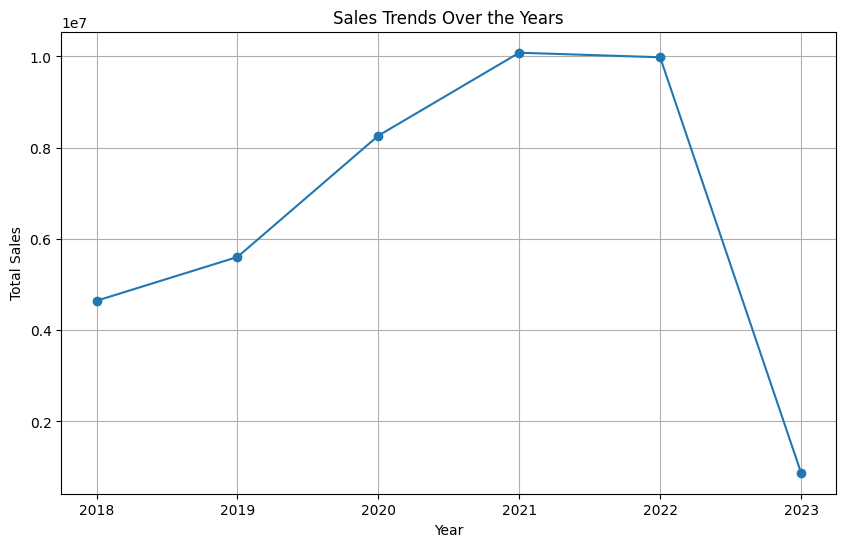

In [55]:
sales_by_year = purchases.groupby('Year')['Total Spending'].sum().reset_index()

# Create a line plot to show sales trends over the years.
plt.figure(figsize=(10, 6))
plt.plot(sales_by_year['Year'], sales_by_year['Total Spending'], marker='o')
plt.title("Sales Trends Over the Years")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

Total Spending of Each State

In [56]:
state_spending = purchases.groupby('Purchase State', as_index=False)['Total Spending'].sum()
state_spending

,Purchase State,Total Spending
0,AK,45940.70
1,AL,418478.17
2,AR,316379.06
3,AZ,722643.15
4,CA,4105586.55
5,CO,692104.57
6,CT,396710.62
7,DC,156190.39
8,DE,198051.60
9,FL,2531409.82


In [57]:
# Top 25% 
threshold = state_spending['Total Spending'].quantile(0.75)
high_value_states = state_spending[state_spending['Total Spending'] >= threshold]

high_value_states

,Purchase State,Total Spending
4,CA,4105586.55
9,FL,2531409.82
10,GA,1163964.94
14,IL,1636255.52
19,MA,1025238.34
22,MI,1329997.59
27,NC,1581511.86
34,NY,2238773.86
35,OH,1867317.33
38,PA,2087735.27


Category Preference by State

In [58]:
state_category_summary = purchases.groupby(['Purchase State', 'Category']).agg({
    'Total Spending': 'sum',
    'Quantity': 'sum',
    'ASIN/ISBN': 'count' 
}).reset_index().rename(columns={'ASIN/ISBN': 'OrderCount'})

state_category_summary

,Purchase State,Category,Total Spending,Quantity,OrderCount
0,AK,ABIS_BOOK,1353.92,100.0,99
1,AK,ABIS_LAWN_AND_GARDEN,91.19,7.0,2
2,AK,ABIS_MUSIC,37.67,2.0,2
3,AK,ABRASIVE_SHEETS,37.39,1.0,1
4,AK,ABRASIVE_WHEELS,10.99,1.0,1
...,...,...,...,...,...
61647,WY,WEIGH_SCALE,8.98,1.0,1
61648,WY,WIPER_BLADE,24.99,1.0,1
61649,WY,WIRELESS_AUDIO_ADAPTER,25.99,1.0,1
61650,WY,WRITING_BOARD,43.98,2.0,1


High Value Customers

In [59]:
customer_spending = customer_summary.groupby("Survey ResponseID", as_index=False)['Total Spending'].sum()

demographics = surveys[["Survey ResponseID", "Q-demos-age", "Q-demos-income", "Q-demos-state"]]
customer_spending = pd.merge(customer_spending, demographics, on="Survey ResponseID", how="left")

customer_spending

,Survey ResponseID,Total Spending,Q-demos-age,Q-demos-income,Q-demos-state
0,R_01vNIayewjIIKMF,4231.86,35 - 44 years,"$25,000 - $49,999",New Jersey
1,R_037XK72IZBJyF69,15894.58,55 - 64 years,"$25,000 - $49,999",Pennsylvania
2,R_038ZU6kfQ5f89fH,3074.47,25 - 34 years,"$25,000 - $49,999",California
3,R_03aEbghUILs9NxD,3528.40,35 - 44 years,"$50,000 - $74,999",Virginia
4,R_06RZP9pS7kONINr,10424.85,65 and older,"$75,000 - $99,999",South Dakota
...,...,...,...,...,...
4955,R_zd4E1BgAdaM2761,12921.29,25 - 34 years,"$150,000 or more",Illinois
4956,R_zdLOP8JD2pe1brj,6224.64,18 - 24 years,"$50,000 - $74,999",Wisconsin
4957,R_zdQYFhfeqyBd2dH,5914.46,25 - 34 years,"$25,000 - $49,999",Kansas
4958,R_zfnsck2ZatnGtY5,9837.88,25 - 34 years,"$75,000 - $99,999",Ohio


Top 25% Customers Stat

In [60]:
threshold = customer_spending['Total Spending'].quantile(0.75)
customer_spending['Value Segment'] = np.where(customer_spending['Total Spending'] >= threshold, "High Value", "Other")

customer_spending

,Survey ResponseID,Total Spending,Q-demos-age,Q-demos-income,Q-demos-state,Value Segment
0,R_01vNIayewjIIKMF,4231.86,35 - 44 years,"$25,000 - $49,999",New Jersey,Other
1,R_037XK72IZBJyF69,15894.58,55 - 64 years,"$25,000 - $49,999",Pennsylvania,High Value
2,R_038ZU6kfQ5f89fH,3074.47,25 - 34 years,"$25,000 - $49,999",California,Other
3,R_03aEbghUILs9NxD,3528.40,35 - 44 years,"$50,000 - $74,999",Virginia,Other
4,R_06RZP9pS7kONINr,10424.85,65 and older,"$75,000 - $99,999",South Dakota,Other
...,...,...,...,...,...,...
4955,R_zd4E1BgAdaM2761,12921.29,25 - 34 years,"$150,000 or more",Illinois,High Value
4956,R_zdLOP8JD2pe1brj,6224.64,18 - 24 years,"$50,000 - $74,999",Wisconsin,Other
4957,R_zdQYFhfeqyBd2dH,5914.46,25 - 34 years,"$25,000 - $49,999",Kansas,Other
4958,R_zfnsck2ZatnGtY5,9837.88,25 - 34 years,"$75,000 - $99,999",Ohio,Other


In [61]:
high_value_customers = customer_spending.query("`Value Segment` == 'High Value'")
high_value_customers

,Survey ResponseID,Total Spending,Q-demos-age,Q-demos-income,Q-demos-state,Value Segment
1,R_037XK72IZBJyF69,15894.58,55 - 64 years,"$25,000 - $49,999",Pennsylvania,High Value
12,R_0BCm9hRP9iTI081,27953.98,25 - 34 years,"$100,000 - $149,999",Colorado,High Value
17,R_0DoXqOQl0hxEeFH,24926.51,35 - 44 years,"$25,000 - $49,999",Utah,High Value
20,R_0Hzrb8hEmXavTk5,20073.31,25 - 34 years,"$150,000 or more",Illinois,High Value
24,R_0MwMIcbYO11SOwV,14891.02,45 - 54 years,"$25,000 - $49,999",Florida,High Value
...,...,...,...,...,...,...
4935,R_z1mFB9Qp9HSTCIV,17435.55,45 - 54 years,"$50,000 - $74,999",Florida,High Value
4940,R_z6wrYNsvTbmmmQ1,11593.05,45 - 54 years,"$25,000 - $49,999",Washington,High Value
4948,R_zTf2i6s3E2OQZQR,11536.34,55 - 64 years,"$25,000 - $49,999",California,High Value
4950,R_zYlhkltqLl0WShX,12405.32,25 - 34 years,"$75,000 - $99,999",Maryland,High Value


Graph of Customer Spending

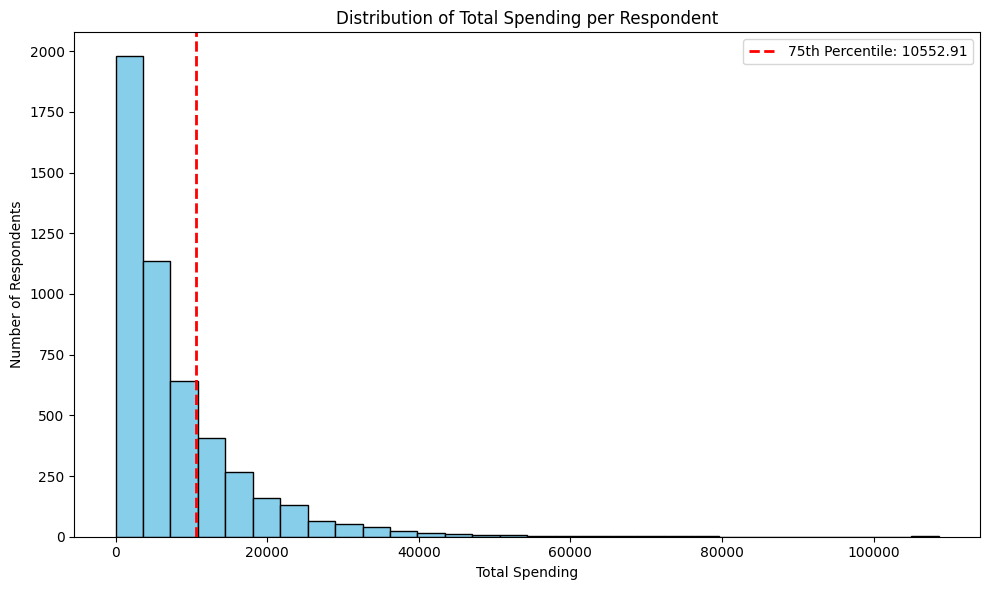

In [62]:
plt.figure(figsize=(10,6))
plt.hist(customer_spending['Total Spending'], bins=30, edgecolor='black', color='skyblue')
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'75th Percentile: {threshold:.2f}')
plt.title("Distribution of Total Spending per Respondent")
plt.xlabel("Total Spending")
plt.ylabel("Number of Respondents")
plt.legend()
plt.tight_layout()
plt.show()

Category Preference by Age

In [63]:
age_category = customer_summary.groupby(["Q-demos-age", "Category"]).agg(
    TotalSpendingSum=('Total Spending', 'sum'),
    OrderCount=('ASIN/ISBN', 'count')
).reset_index()
age_category

,Q-demos-age,Category,TotalSpendingSum,OrderCount
0,18 - 24 years,3D_PRINTER,501.94,5
1,18 - 24 years,ABDOMINAL_EXERCISER,346.40,21
2,18 - 24 years,ABIS_BOOK,185689.15,10330
3,18 - 24 years,ABIS_DRUGSTORE,50.25,6
4,18 - 24 years,ABIS_DVD,555.51,32
...,...,...,...,...
9904,65 and older,WRITING_INSTRUMENT,1437.09,134
9905,65 and older,WRITING_PAPER,67.70,3
9906,65 and older,YARN,784.79,53
9907,65 and older,YO_YO,41.98,2


In [64]:
# Top Category by Age
top_category_by_age = age_category.loc[age_category.groupby("Q-demos-age")["OrderCount"].idxmax()].reset_index(drop=True)
top_category_by_age

,Q-demos-age,Category,TotalSpendingSum,OrderCount
0,18 - 24 years,ABIS_BOOK,185689.15,10330
1,25 - 34 years,ABIS_BOOK,427737.06,25772
2,35 - 44 years,ABIS_BOOK,341234.88,25181
3,45 - 54 years,ABIS_BOOK,212040.64,14279
4,55 - 64 years,ABIS_BOOK,102750.42,6438
5,65 and older,ABIS_BOOK,39430.61,2738


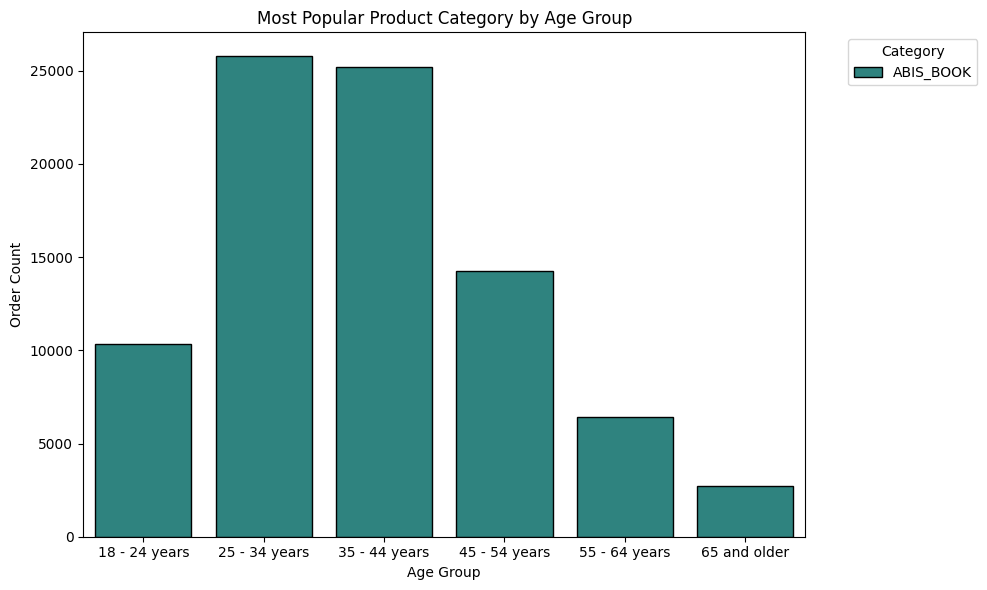

In [65]:
# Graph
plt.figure(figsize=(10, 6))
sns.barplot(data=top_category_by_age, x="Q-demos-age", y="OrderCount", hue="Category", dodge=False, palette="viridis", edgecolor="black")
plt.title("Most Popular Product Category by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Order Count")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Category Preference by State

In [66]:
state_category = customer_summary.groupby(["Q-demos-state", "Category"]).agg(
    TotalSpendingSum=('Total Spending', 'sum'),
    OrderCount=('ASIN/ISBN', 'count')
).reset_index()

state_category

,Q-demos-state,Category,TotalSpendingSum,OrderCount
0,Alabama,3D_PRINTER,39.99,1
1,Alabama,ABIS_BOOK,14817.37,940
2,Alabama,ABIS_DVD,301.62,17
3,Alabama,ABIS_ELECTRONICS,69.99,1
4,Alabama,ABIS_GIFT_CARD,195.00,9
...,...,...,...,...
61595,Wyoming,WEIGH_SCALE,8.98,1
61596,Wyoming,WIPER_BLADE,24.99,1
61597,Wyoming,WIRELESS_AUDIO_ADAPTER,25.99,1
61598,Wyoming,WRITING_BOARD,43.98,1


In [67]:
top_category_by_state = state_category.loc[state_category.groupby("Q-demos-state")["OrderCount"].idxmax()].reset_index(drop=True)
top_category_by_state

,Q-demos-state,Category,TotalSpendingSum,OrderCount
0,Alabama,ABIS_BOOK,14817.37,940
1,Alaska,ABIS_BOOK,1766.03,111
2,Arizona,ABIS_BOOK,23627.56,1620
3,Arkansas,ABIS_BOOK,14347.40,840
4,California,ABIS_BOOK,119721.80,7580
5,Colorado,ABIS_BOOK,26170.05,1553
6,Connecticut,ABIS_BOOK,14433.55,877
7,Delaware,ABIS_BOOK,4686.79,303
8,District of Columbia,PET_FOOD,8660.06,383
9,Florida,ABIS_BOOK,74047.33,4563


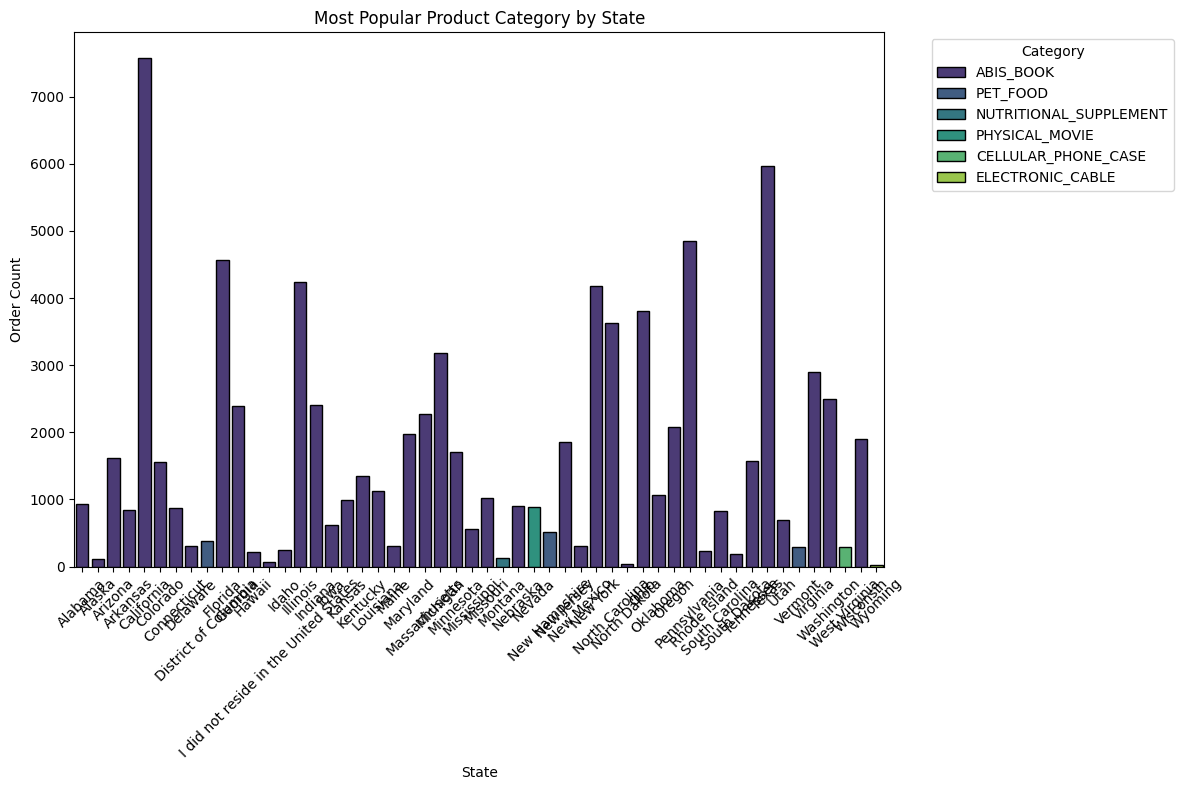

In [68]:
# Graph of Category by State
plt.figure(figsize=(12,8))
sns.barplot(
    data=top_category_by_state, 
    x="Q-demos-state", 
    y="OrderCount", 
    hue="Category", 
    dodge=False, 
    palette="viridis",
    edgecolor="black"
)
plt.title("Most Popular Product Category by State")
plt.xlabel("State")
plt.ylabel("Order Count")
plt.xticks(rotation=45)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [69]:
# Prefered Category in Order for Each State
combined_df = customer_summary.groupby(["Q-demos-state", "Category"], as_index=False).agg(OrderCount=('ASIN/ISBN', 'count'))
combined_df['Rank'] = combined_df.groupby('Q-demos-state')['OrderCount'].rank(method='min', ascending=False).astype(int)

combined_df = combined_df.sort_values(["Q-demos-state", "Rank"]).reset_index(drop=True)

combined_df

,Q-demos-state,Category,OrderCount,Rank
0,Alabama,ABIS_BOOK,940,1
1,Alabama,PET_FOOD,394,2
2,Alabama,SHIRT,342,3
3,Alabama,COFFEE,231,4
4,Alabama,TOY_FIGURE,229,5
...,...,...,...,...
61595,Wyoming,WATER_FLOTATION_DEVICE,1,136
61596,Wyoming,WEIGH_SCALE,1,136
61597,Wyoming,WIPER_BLADE,1,136
61598,Wyoming,WIRELESS_AUDIO_ADAPTER,1,136


In [70]:
specific_state = "Oregon"
state_ranking = combined_df[combined_df["Q-demos-state"] == specific_state]
state_ranking

,Q-demos-state,Category,OrderCount,Rank
45357,Oregon,ABIS_BOOK,2081,1
45358,Oregon,PET_FOOD,599,2
45359,Oregon,NUTRITIONAL_SUPPLEMENT,570,3
45360,Oregon,SHIRT,478,4
45361,Oregon,VEGETABLE,333,5
...,...,...,...,...
46784,Oregon,VIDEO_GAME_HARDWARE,1,1256
46785,Oregon,WATER_HEATER,1,1256
46786,Oregon,WEIGHT_PLATE,1,1256
46787,Oregon,WORKBENCH,1,1256


Prefered Category by Income Bracket

In [71]:
income_category = customer_summary.groupby(["Q-demos-income", "Category"]).agg(
    TotalSpendingSum=('Total Spending', 'sum'),
    OrderCount=('ASIN/ISBN', 'count')
).reset_index()

income_category

,Q-demos-income,Category,TotalSpendingSum,OrderCount
0,"$100,000 - $149,999",3D_GLASSES,9.99,1
1,"$100,000 - $149,999",3D_PRINTER,8422.56,36
2,"$100,000 - $149,999",3D_PRINTING_PEN,59.99,1
3,"$100,000 - $149,999",ABDOMINAL_EXERCISER,964.45,32
4,"$100,000 - $149,999",ABIS_APPAREL,13.94,2
...,...,...,...,...
11311,Prefer not to say,WRITING_INSTRUMENT,1687.57,129
11312,Prefer not to say,WRITING_PAPER,56.82,6
11313,Prefer not to say,YARN,255.40,21
11314,Prefer not to say,YO_YO,12.99,1


In [72]:
top_category_by_income = income_category.loc[
    income_category.groupby("Q-demos-income")["OrderCount"].idxmax()
].reset_index(drop=True)

top_category_by_income

,Q-demos-income,Category,TotalSpendingSum,OrderCount
0,"$100,000 - $149,999",ABIS_BOOK,252391.52,17374
1,"$150,000 or more",ABIS_BOOK,204999.50,12820
2,"$25,000 - $49,999",ABIS_BOOK,232833.78,15268
3,"$50,000 - $74,999",ABIS_BOOK,262948.14,16422
4,"$75,000 - $99,999",ABIS_BOOK,212861.74,13996
5,"Less than $25,000",ABIS_BOOK,127906.58,7977
6,Prefer not to say,ABIS_BOOK,14941.50,881


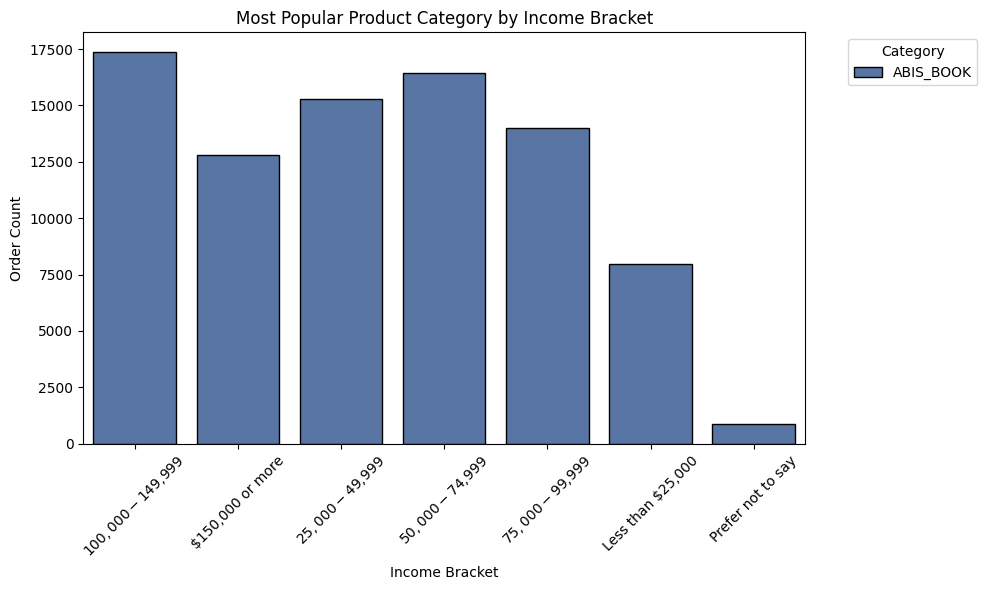

In [73]:
# Graph of the most popular product by State
plt.figure(figsize=(10, 6))
sns.barplot(data=top_category_by_income,
            x="Q-demos-income",
            y="OrderCount",
            hue="Category",
            dodge=False,
            palette="deep",
            edgecolor="black")
plt.title("Most Popular Product Category by Income Bracket")
plt.xlabel("Income Bracket")
plt.ylabel("Order Count")
plt.xticks(rotation=45)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Total spendings by Age bracket')

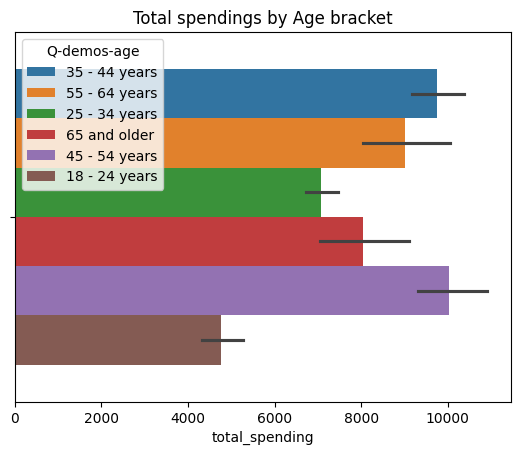

In [94]:
# Graph of Income vs. Age
sns.barplot(customer_behavior, x='total_spending', hue='Q-demos-age')
plt.title('Total spendings by Age bracket')

Text(0.5, 1.0, 'Total spendings by Income bracket')

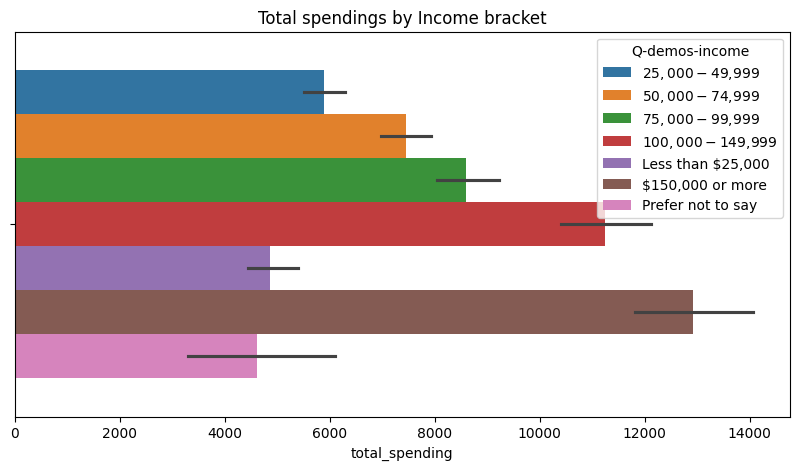

In [95]:
# Graph of Total Spendings vs. Income
plt.figure(figsize=(10,5))
sns.barplot(customer_behavior, x='total_spending', hue='Q-demos-income')
plt.title('Total spendings by Income bracket')

# Clustering 

In [74]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

Customer Behavior Based on Value, Income, and Age

In [75]:
customer_behavior = purchases.groupby('Survey ResponseID').agg({
    'Order Date': 'max',      
    'Total Spending': 'sum',        
    'ASIN/ISBN': 'count'
}).reset_index()

customer_behavior = purchases.groupby('Survey ResponseID').agg({     
    'Total Spending': ['mean','sum'],           
    'ASIN/ISBN': 'count'
}).reset_index()

customer_behavior.columns = ['Survey ResponseID', 'mean_spending', 'total_spending', 'total_purchases']
scaler = StandardScaler()
scaled_customer_behavior = scaler.fit_transform(pd.DataFrame(customer_behavior['total_purchases']))

ssd = []

for i in range(2,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_customer_behavior)
    ssd.append(kmeans.inertia_)

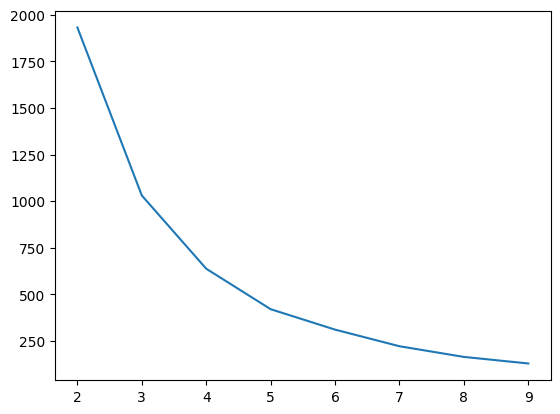

In [76]:
# Elbow Plot
plt.plot(list(range(2,10)), ssd)

<Axes: xlabel='total_purchases'>

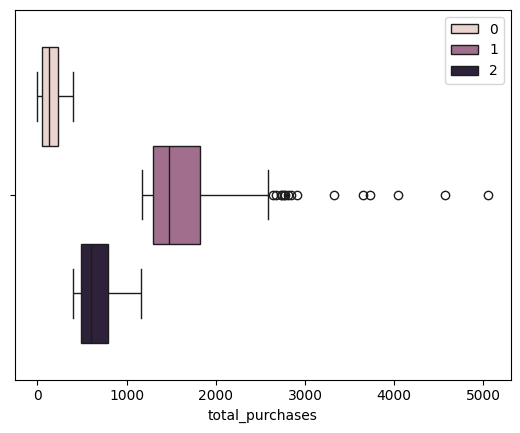

In [77]:
# KMeans
kmeans = KMeans(n_clusters=3, random_state=101) 
most_purchases_labels = kmeans.fit_predict(scaled_customer_behavior)

#Plot
sns.boxplot(x=customer_behavior['total_purchases'], hue=most_purchases_labels)

Clustering Based on Total Spending

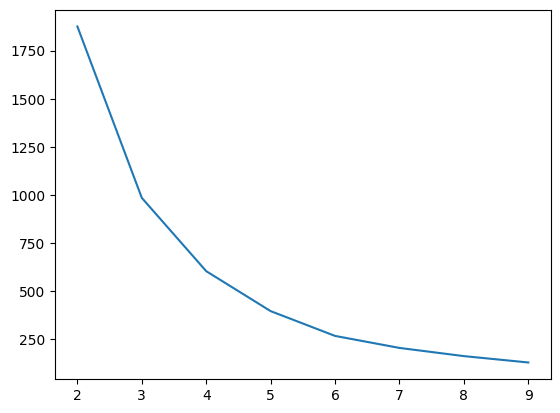

In [78]:
scaler = StandardScaler()
scaled_customer_behavior = scaler.fit_transform(pd.DataFrame(customer_behavior['total_spending']))

ssd = []

for i in range(2,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_customer_behavior)
    ssd.append(kmeans.inertia_)

# Plot
plt.plot(list(range(2,10)), ssd)

<Axes: xlabel='total_spending'>

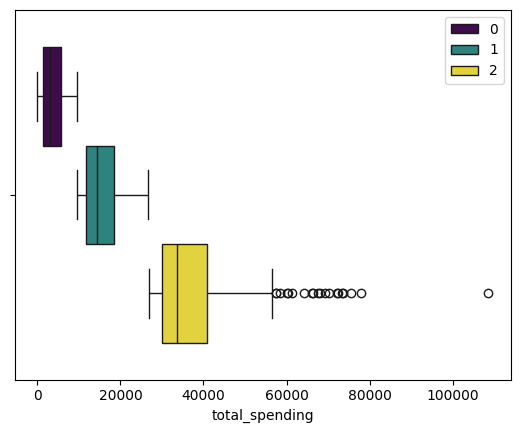

In [79]:
kmeans = KMeans(n_clusters=3, random_state=101) 
most_spending_labels = kmeans.fit_predict(scaled_customer_behavior)
sns.boxplot(x=customer_behavior['total_spending'], hue=most_spending_labels, palette='viridis')

Clustering Based on Mean Spendings

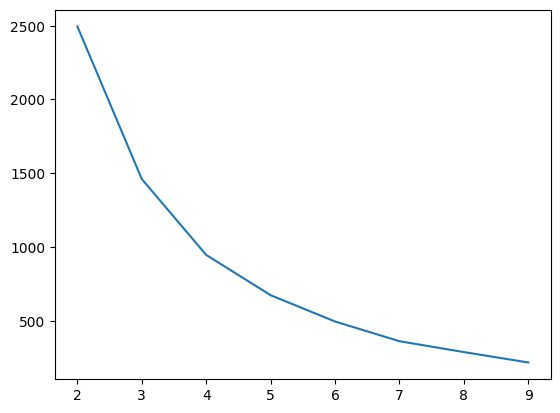

In [80]:
scaler = StandardScaler()
scaled_customer_behavior = scaler.fit_transform(pd.DataFrame(customer_behavior['mean_spending']))

ssd = []

for i in range(2,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_customer_behavior)
    ssd.append(kmeans.inertia_)

# Plot
plt.plot(list(range(2,10)), ssd)

<Axes: xlabel='mean_spending'>

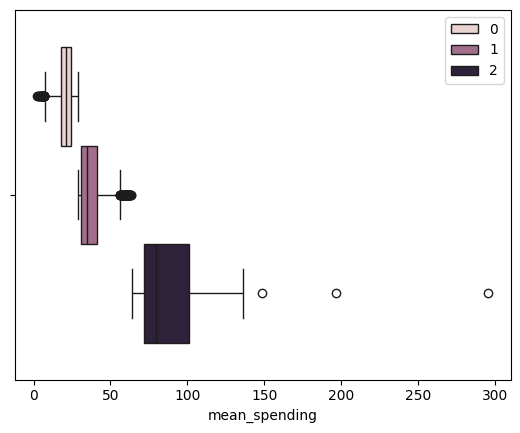

In [81]:
# KMeans
kmeans = KMeans(n_clusters=3, random_state=101) 
mean_spending_labels = kmeans.fit_predict(scaled_customer_behavior)
sns.boxplot(x=customer_behavior['mean_spending'], hue=mean_spending_labels)

Renaming Based on Clustered Labels

In [82]:
# Reset Dataset and merge
customer_behavior.reset_index(inplace=True)
labels = pd.DataFrame({'most_purchases_labels': most_purchases_labels , 'total_spendings_labels' : most_spending_labels, 'mean_spendings_labels' : mean_spending_labels })
customer_behavior = pd.merge(customer_behavior, labels, left_index=True, right_index=True, how='left')

In [83]:
# Labels for Most Purchased
customer_behavior['most_purchases_labels'] = customer_behavior['most_purchases_labels'].astype(str)
total_purchases = customer_behavior[customer_behavior['most_purchases_labels'] == '0']['total_purchases']
customer_behavior.loc[customer_behavior['most_purchases_labels'] == '0', 'most_purchases_labels']  = f'{total_purchases.min()} - {total_purchases.max()}'

total_purchases = customer_behavior[customer_behavior['most_purchases_labels'] == '1']['total_purchases']
customer_behavior.loc[customer_behavior['most_purchases_labels'] == '1', 'most_purchases_labels']  = f'{total_purchases.min()} - {total_purchases.max()}'

total_purchases = customer_behavior[customer_behavior['most_purchases_labels'] == '2']['total_purchases']
customer_behavior.loc[customer_behavior['most_purchases_labels'] == '2', 'most_purchases_labels']  = f'{total_purchases.min()} - {total_purchases.max()}'

In [84]:
# Labels for Total Spendings
customer_behavior['total_spendings_labels'] = customer_behavior['total_spendings_labels'].astype(str)
total_purchases = customer_behavior[customer_behavior['total_spendings_labels'] == '0']['total_spending']
customer_behavior.loc[customer_behavior['total_spendings_labels'] == '0', 'total_spendings_labels']  = f'{int(total_purchases.min())} - {int(total_purchases.max())}$'

total_purchases = customer_behavior[customer_behavior['total_spendings_labels'] == '1']['total_spending']
customer_behavior.loc[customer_behavior['total_spendings_labels'] == '1', 'total_spendings_labels']  = f'{int(total_purchases.min())} - {int(total_purchases.max())}$'

total_purchases = customer_behavior[customer_behavior['total_spendings_labels'] == '2']['total_spending']
customer_behavior.loc[customer_behavior['total_spendings_labels'] == '2', 'total_spendings_labels']  = f'{int(total_purchases.min())} - {int(total_purchases.max())}$'

In [85]:
# Labels for Mean Spendings
customer_behavior['mean_spendings_labels'] = customer_behavior['mean_spendings_labels'].astype(str)
total_purchases = customer_behavior[customer_behavior['mean_spendings_labels'] == '0']['mean_spending']
customer_behavior.loc[customer_behavior['mean_spendings_labels'] == '0', 'mean_spendings_labels']  = f'{int(total_purchases.min())} - {int(total_purchases.max())}$'

total_purchases = customer_behavior[customer_behavior['mean_spendings_labels'] == '1']['mean_spending']
customer_behavior.loc[customer_behavior['mean_spendings_labels'] == '1', 'mean_spendings_labels']  = f'{int(total_purchases.min())} - {int(total_purchases.max())}$'

total_purchases = customer_behavior[customer_behavior['mean_spendings_labels'] == '2']['mean_spending']
customer_behavior.loc[customer_behavior['mean_spendings_labels'] == '2', 'mean_spendings_labels']  = f'{int(total_purchases.min())} - {int(total_purchases.max())}$'

In [86]:
customer_behavior

,index,Survey ResponseID,mean_spending,total_spending,total_purchases,most_purchases_labels,total_spendings_labels,mean_spendings_labels
0,0,R_01vNIayewjIIKMF,35.863220,4231.86,118,1 - 404,2 - 9550$,28 - 63$
1,1,R_037XK72IZBJyF69,13.725889,15894.58,1158,405 - 1167,9580 - 26745$,2 - 28$
2,2,R_038ZU6kfQ5f89fH,93.165758,3074.47,33,1 - 404,2 - 9550$,63 - 295$
3,3,R_03aEbghUILs9NxD,22.331646,3528.40,158,1 - 404,2 - 9550$,2 - 28$
4,4,R_06RZP9pS7kONINr,25.364599,10424.85,411,405 - 1167,9580 - 26745$,2 - 28$
...,...,...,...,...,...,...,...,...
4955,4955,R_zd4E1BgAdaM2761,25.842580,12921.29,500,405 - 1167,9580 - 26745$,2 - 28$
4956,4956,R_zdLOP8JD2pe1brj,19.760762,6224.64,315,1 - 404,2 - 9550$,2 - 28$
4957,4957,R_zdQYFhfeqyBd2dH,24.239590,5914.46,244,1 - 404,2 - 9550$,2 - 28$
4958,4958,R_zfnsck2ZatnGtY5,17.259439,9837.88,570,405 - 1167,9580 - 26745$,2 - 28$


Based on Age

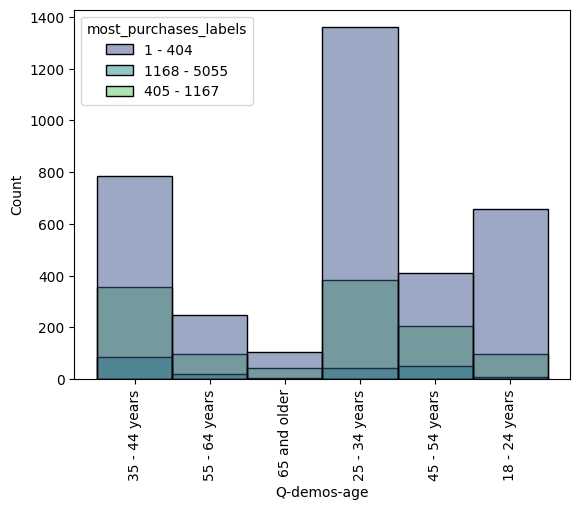

In [87]:
customer_behavior = pd.merge(customer_behavior, surveys[['Survey ResponseID', 'Q-demos-age','Q-demos-income', 'Q-demos-state']], how='inner')

# Plot based on most purchases labels
sns.histplot(customer_behavior.sort_values(by='most_purchases_labels'), x='Q-demos-age', hue='most_purchases_labels', palette='viridis')
plt.xticks(rotation=90);

1. Which age groups make the most purchases overall?

   Ans: The 25-34 years group has the highest count overall, followed by 35-44 years and 18-24 years.

2. How are the purchases distributed within each age group?

    1 - 404 (low)
    
    405 - 1167 (medium)
    
    1168 - 5055 (high)

    Ans: Most people fall into the low purchase range (1–404) across all age groups, especially in the younger and older age groups.

3. Which age group has the most high-volume purchasers?

    Ans: The 25–34 and 35–44 groups have more medium to high-volume purchasers compared to other age groups.

4. Are there any age groups with very few high-volume buyers?

   Ans: Yes, groups like 65 and older and 55–64 have relatively low participation in higher purchase brackets.

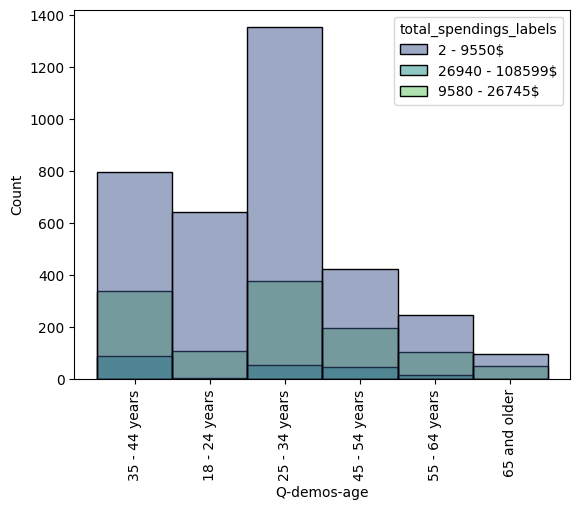

In [88]:
# Plot based on Total Spendings Labels
sns.histplot(customer_behavior.sort_values(by='total_spendings_labels'), x='Q-demos-age', hue='total_spendings_labels', palette='viridis')
plt.xticks(rotation=90);

1. Which age groups spend the most overall?
    Sol: The 25–34 years group again leads, with 35–44 years and 18–24 years following.

2. How is total spending distributed within each age group?

    2 – 9,550$ (low spenders)
    
    9,580 – 26,745$ (medium spenders)
    
    26,940 – 108,599$ (high spenders)
    
    Most people across all age groups fall into the low spending category. However, 25–34 and 35–44 have notable portions of medium and high spenders.

3. Which age group contains the most high spenders?
    The green section of each bar representing 26,940 – 108,599$ indicates high spenders.

    The 25–34 group has the most high spenders.
    
    The 35–44 group also contributes significantly.
    
    Very few high spenders exist in the 65 and older and 55–64 groups.

4. Are there age groups that tend to spend less overall?

    Sol: 65 and older and 55–64 years have both lower total participation and lower representation in higher spending brackets.

5. Does age influence both purchase count and total spending?
    Comparing this chart with the previous one:

    25–34 years consistently shows the highest activity in both purchases and total spending.
    
    Older age groups are less active both in purchase count and total spend.
    
    The 18–24 group makes a fair number of purchases but has fewer high spenders, suggesting lower-value purchases.

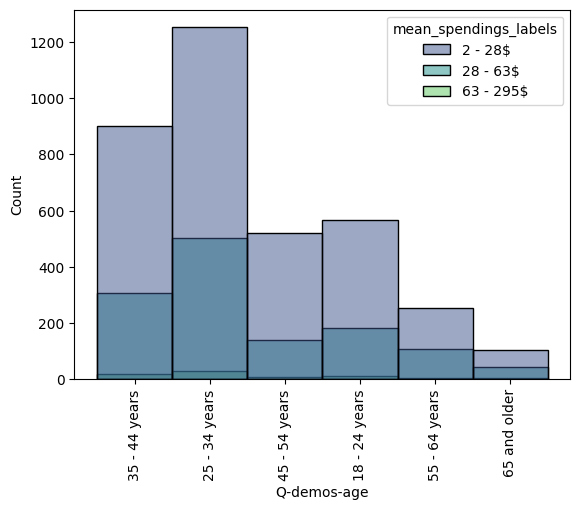

In [89]:
# Plot Based on Mean Spendings Labels
sns.histplot(customer_behavior.sort_values(by='mean_spendings_labels'), x='Q-demos-age', hue='mean_spendings_labels', palette='viridis')
plt.xticks(rotation=90);

1. Which age groups have the highest average spending per person?
    The 25–34 and 35–44 age groups show the highest concentration of medium to high average spenders.

2. Which age groups tend to spend the least on average?


   The 65 and older, 55–64, and 18–24 groups are predominantly in the low average spending range of 2–28$.


    This suggests their purchases may be more frequent but involve lower-value items?

3. Does high total spending correlate with high average spending?


   This graph shows that the 25–34 group likely buying often and spending significantly per purchase.

4. Are there any groups that spend frequently but not much per transaction?


   The 18–24 group had decent total purchases but shows mostly low average spending, suggesting frequent but small purchases.

5. Which group is most balanced across frequency and value?

    25–34 years stands out consistently across all three charts (most purchases, highest total spend, decent average spend).

    35–44 years follows closely in terms of average and total value, though with slightly fewer high-frequency purchasers than 25–34.

Based on Income

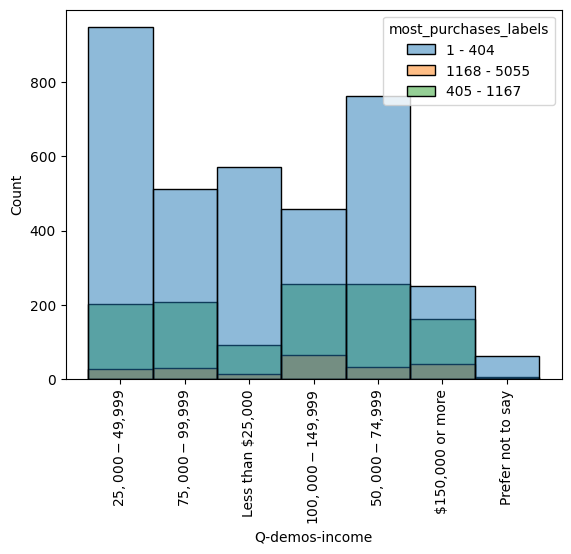

In [90]:
# Plot Based on Most Purchased Label
sns.histplot(customer_behavior.sort_values(by='most_purchases_labels'), x='Q-demos-income', hue='most_purchases_labels')
plt.xticks(rotation=90);

1. Which income groups have the highest purchase frequency?
    The 25,000–49,999 and 50,000–74,999 income groups show the highest concentration of medium to high purchase counts, suggesting these brackets are actively engaging in frequent purchasing.

2. Which income groups tend to purchase the least?
    The "Less than 25,000", "150,000 or more", and "Prefer not to say" groups are predominantly in the low purchase frequency range, indicating less overall activity.

3. Do higher-income groups spend more frequently?
    Surprisingly, the highest income group ($150,000 or more) doesn’t show a strong presence in the high purchase category. This suggests that high income doesn't always correlate with high purchase frequency — perhaps these individuals make fewer but more expensive purchases.

4. Which groups might be making frequent but lower-value purchases?
    The $25,000–49,999 group has a strong presence in the high-frequency, low-spending range. This could imply they’re making more routine or smaller-value transactions rather than large, infrequent ones.

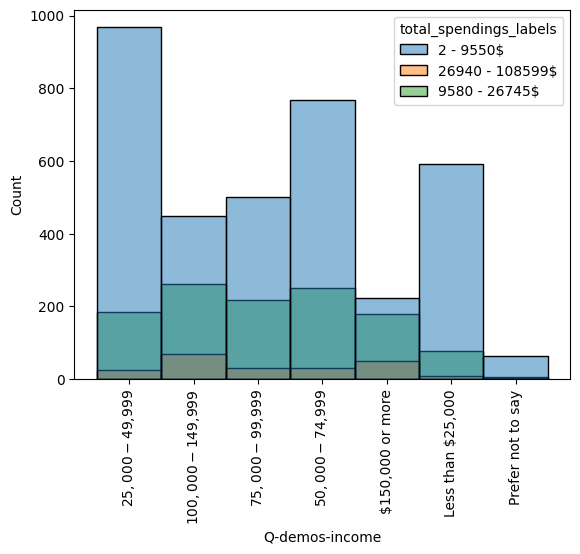

In [91]:
# Based on Total Spendings Labels
sns.histplot(customer_behavior.sort_values(by='total_spendings_labels'), x='Q-demos-income', hue='total_spendings_labels')
plt.xticks(rotation=90);

1. Which income groups have the highest total spending?

    The 100,000–149,999 income group shows the highest concentration of high total spenders (orange), followed closely by the 150,000 or more and $75,000–99,999 groups. This suggests that people in these brackets are likely making larger or more numerous purchases overall.

2. Which income groups tend to spend the least in total?

    The 25,000–49,999 and Less than $25,000 income groups are heavily concentrated in the lowest total spending tier (blue), pointing to limited overall spending power.

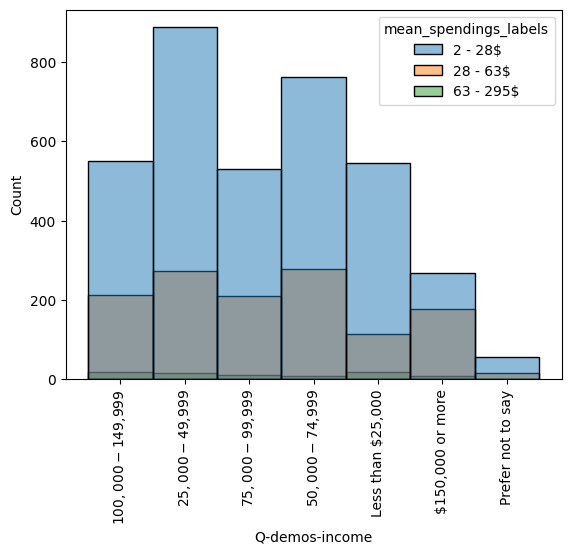

In [92]:
# Plot Based on Mean Spendings Labels

sns.histplot(customer_behavior.sort_values(by='mean_spendings_labels'), x='Q-demos-income', hue='mean_spendings_labels')
plt.xticks(rotation=90);

1. Which income groups have the highest average spending per transaction?
    The Lessa than 25,000, 100,000-149,999 and 25,000–49,999 groups show the clearest presence in the highest average spend tier ($63–295). These individuals tend to spend significantly per transaction, even if less frequently overall.

2. Which income groups tend to spend the least on average per transaction?
    The 25,000–49,999, and 50,000–74,999, Less than 25,000 groups are dominated by the lowest average spend range ($2–28). These groups may still make purchases often, but the individual transaction values are likely small.

Clustering Based on State

Text(0.5, 1.0, 'Cluster spread on the states based on most purchases')

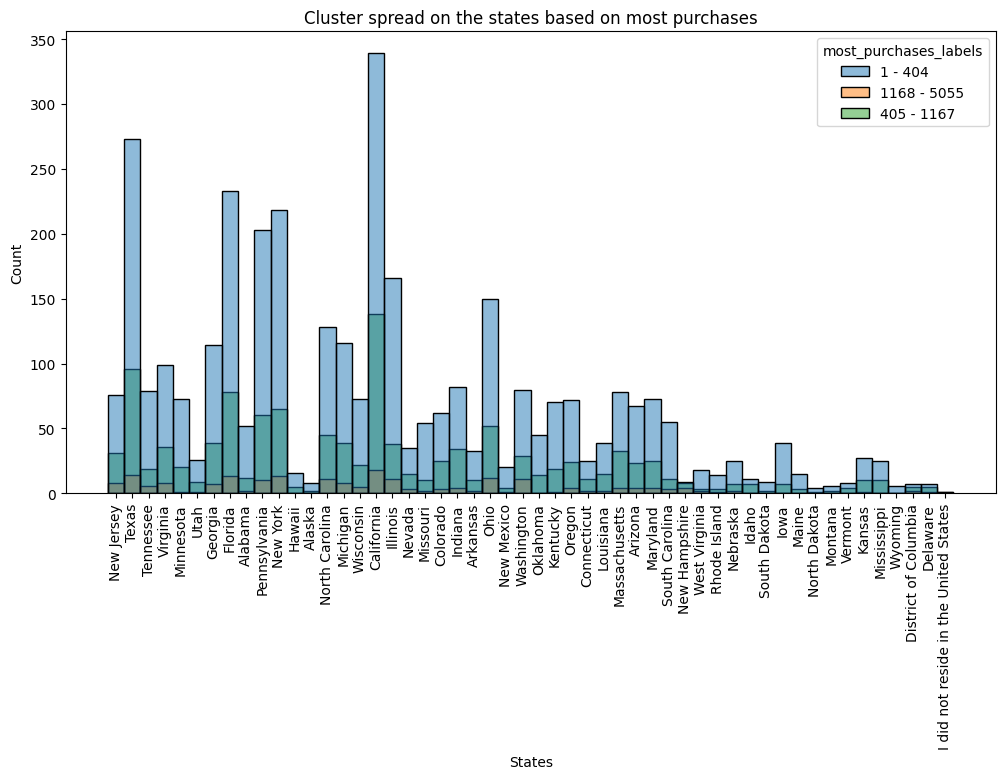

In [ ]:
# Plot of States Based on Most Purchases
plt.figure(dpi=100, figsize=(12,6))
sns.histplot(customer_behavior.sort_values(by='most_purchases_labels'), x='Q-demos-state', hue='most_purchases_labels')
plt.xticks(rotation=90);
plt.xlabel('States')
plt.title('Cluster spread on the states based on most purchases')

1. Which states have the most of the highest purchase frequency per customer?
    Texas and Newyork followed by Illinois with purchase frequency of 1168 - 5055 per customer.

2. Which states have the most of the least purchase frequency overall?
    California followed by texas with purchase frequency of 1 - 404 per customer.

3. The highest of the middle tier purchase frequency: California

4.    lowest purchase frequency state: Montana

In [ ]:
# Plot of States Based on Total Spendings
plt.figure(dpi=100, figsize=(12,6))
sns.histplot(customer_behavior.sort_values(by='total_spendings_labels'), x='Q-demos-state', hue='total_spendings_labels')
plt.xticks(rotation=90)
plt.xlabel('States')
plt.title('Cluster spread on the states based on total spendings')

1. Which states have the most of the highest spending  per customer?
    California.

2. Which states have the most of the least purchase frequency overall?
    California.

3. The highest of the middle tier purchase frequency: 
    California

4. lowest spending state: 
    Montana

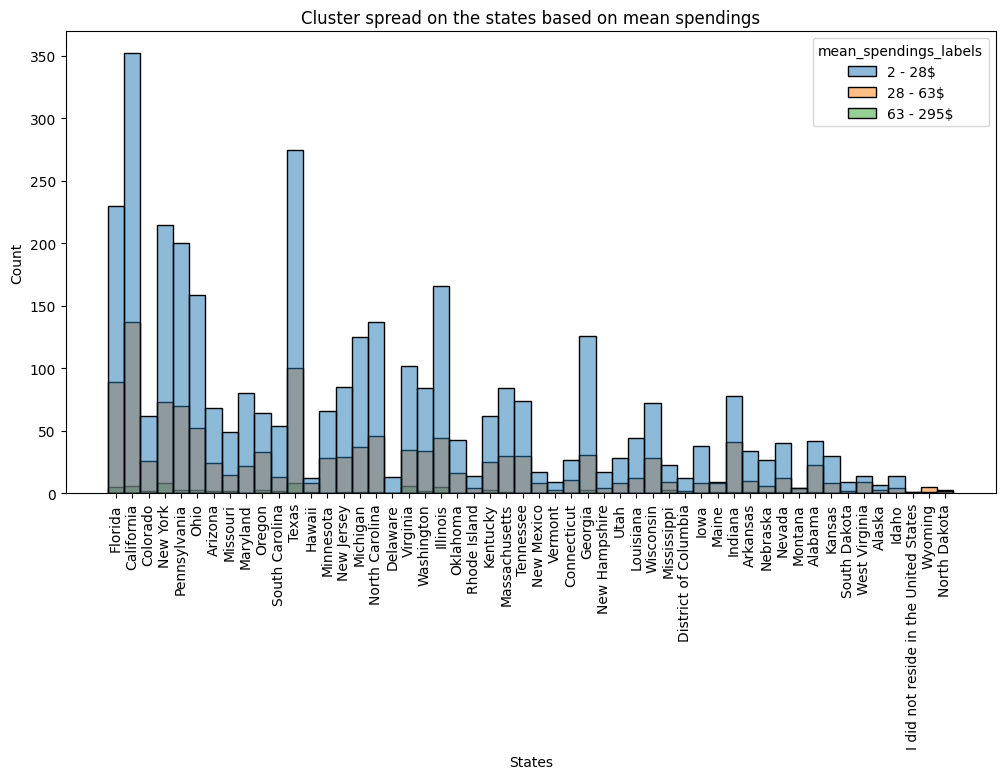

In [97]:
# Plot of States Based on Mean Spendings
plt.figure(dpi=100, figsize=(12,6))
sns.histplot(customer_behavior.sort_values(by='mean_spendings_labels'), x='Q-demos-state', hue='mean_spendings_labels')
plt.xticks(rotation=90)
plt.xlabel('States')
plt.title('Cluster spread on the states based on mean spendings');

1. Which states have the most of the highest spending  per customer?
    Texas, New york.

2. Which states have the most of the least purchase frequency overall?
    California.

3. The highest of the middle tier purchase frequency: California

4. lowest spending state: Montana

# Holidays Dataset

In [98]:
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("donnetew/us-holiday-dates-2004-2021")

print("Path to dataset files:", path)

Note: you may need to restart the kernel to use updated packages.


100%|██████████| 2.45k/2.45k [00:00<00:00, 405kB/s]

Extracting files...
Path to dataset files: C:\Users\shwet\.cache\kagglehub\datasets\donnetew\us-holiday-dates-2004-2021\versions\1


In [99]:
holidays = pd.read_csv(os.path.join(path,'US Holiday Dates (2004-2021).csv'))

In [100]:
holidays['is_holiday'] = True
holidays['Date'] = pd.to_datetime(holidays['Date'])

In [101]:
holidays

,Date,Holiday,WeekDay,Month,Day,Year,is_holiday
0,2004-07-04,4th of July,Sunday,7,4,2004,True
1,2005-07-04,4th of July,Monday,7,4,2005,True
2,2006-07-04,4th of July,Tuesday,7,4,2006,True
3,2007-07-04,4th of July,Wednesday,7,4,2007,True
4,2008-07-04,4th of July,Friday,7,4,2008,True
...,...,...,...,...,...,...,...
337,2006-04-16,Western Easter,Sunday,4,16,2006,True
338,2017-04-16,Western Easter,Sunday,4,16,2017,True
339,2014-04-20,Western Easter,Sunday,4,20,2014,True
340,2019-04-21,Western Easter,Sunday,4,21,2019,True


## Inflation Dataset

In [102]:
path = fetch_dataset("1uuTBlEA2caOIyv4-R_G2OlekBCw-i_Le", "inflation.csv")
inflation_df = pd.read_csv(path)
inflation_df['observation_date'] = pd.to_datetime(inflation_df['observation_date'])
inflation_df = inflation_df.rename(columns={'T10YIEM':'inflation_rate'}).set_index('observation_date')

inflation.csv path: c:\Users\shwet\Documents\Spring 2025\DS 5010\Final Project\AmazonSalesPredictor\inflation.csv


In [103]:
inflation_df

,inflation_rate
observation_date,
2018-01-01,2.04
2018-02-01,2.10
2018-03-01,2.09
2018-04-01,2.13
2018-05-01,2.14
2018-06-01,2.12
2018-07-01,2.12
2018-08-01,2.10
2018-09-01,2.12


## EDA

Text(0, 0.5, 'inflation rate')

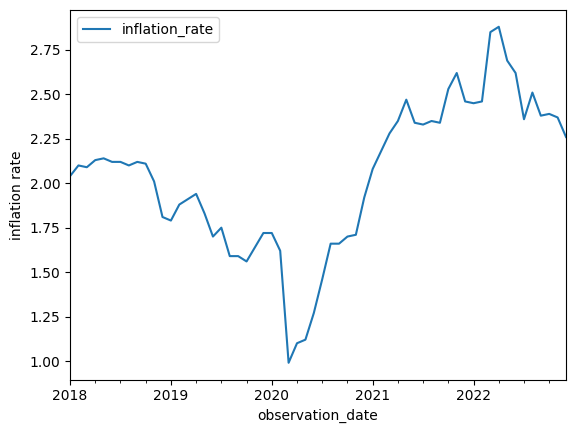

In [104]:
inflation_df.plot()
plt.ylabel('inflation rate')